In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

%matplotlib inline

In [3]:
source_folder = 'C:\\Users\\EMBA\\Documents\\Technical_Training\\Machine Learning - Stock Market trading\\Yes Bank\\Data\\Featurized\\'
target_folder = 'C:\\Users\\EMBA\\Documents\\Technical_Training\\Machine Learning - Stock Market trading\\Yes Bank\\Data\\Clustered\\'
file_name_actionable = 'Yesbank_Actionable_Signals_2017-10-26.csv'
file_name = 'Yesbank_2017-10-26.csv'
source_file_path = source_folder +  file_name
target_file_path = target_folder + file_name
pd_stock_data = pd.read_csv(source_file_path)

In [3]:
attr_cols = (pd_stock_data.columns).tolist()
signal_cols = []
for i in attr_cols:
    attr_list=[]
    attr_list = i.split('_')
    if 'Signal' in attr_list:
        signal_cols.append(i)
pd_stock_data_features = pd_stock_data[signal_cols]
stock_data_features = pd_stock_data_features.as_matrix()

In [9]:
signal_cols

['DF_FPR_Signal_30',
 'DF_FVC_Signal_30',
 'RB_FPR_Signal_30',
 'RB_FVC_Signal_30',
 'DF_FPR_Signal_50',
 'DF_FVC_Signal_50',
 'RB_FPR_Signal_50',
 'RB_FVC_Signal_50',
 'DF_FPR_Signal_150',
 'DF_FVC_Signal_150',
 'RB_FPR_Signal_150',
 'RB_FVC_Signal_150',
 'DF_FPR_Signal_200',
 'DF_FVC_Signal_200',
 'RB_FPR_Signal_200',
 'RB_FVC_Signal_200']

In [31]:
#pd_stock_data[(pd_stock_data["DF_FPR_Signal_30" ]!=0)&
#(pd_stock_data["DF_FVC_Signal_30" ]!=0)&
#(pd_stock_data["RB_FPR_Signal_30" ]!=0)&
#(pd_stock_data["RB_FVC_Signal_30" ]!=0)&
#(pd_stock_data["DF_FPR_Signal_50" ]!=0)&
#(pd_stock_data["DF_FVC_Signal_50" ]!=0)&
#(pd_stock_data["RB_FPR_Signal_50" ]!=0)&
#(pd_stock_data["RB_FVC_Signal_50" ]!=0)&
#(pd_stock_data["DF_FPR_Signal_150" ]!=0)&
#(pd_stock_data["DF_FVC_Signal_150" ]!=0)&
#(pd_stock_data["RB_FPR_Signal_150" ]!=0)&
#(pd_stock_data["RB_FVC_Signal_150" ]!=0)&
#(pd_stock_data["DF_FPR_Signal_200" ]!=0)&
#(pd_stock_data["DF_FVC_Signal_200" ]!=0)&
#(pd_stock_data["RB_FPR_Signal_200" ]!=0)&
#(pd_stock_data["RB_FVC_Signal_200" ]!=0)]

In [219]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    #centroids[0] = data[idx,:].toarray()
    centroids[0] = data[idx,:]
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        #centroids[i] = data[idx,:].toarray()
        centroids[i] = data[idx,:]
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [220]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data,centroids,metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids,axis=1)
    
    return cluster_assignment

In [221]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment ==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        #centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [222]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [223]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [224]:
k = 10
heterogeneity_smart = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(stock_data_features, k, seed)
    centroids, cluster_assignment = kmeans(stock_data_features, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    print ('distribution of cluster assignment ' +str(np.bincount(cluster_assignment)))
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(stock_data_features, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()

distribution of cluster assignment [1558  271  155  220   74  253   98  113  186   98]
seed=000000, heterogeneity=15741.65751
distribution of cluster assignment [1778  271  156  237  157  178   65   45   44   95]
seed=020000, heterogeneity=15152.50976
distribution of cluster assignment [1702  144  111  189  203   95  128  253  125   76]
seed=040000, heterogeneity=14953.34211
distribution of cluster assignment [1778  113  103  253   98   98   62  271  181   69]
seed=060000, heterogeneity=15539.43202
distribution of cluster assignment [ 177 1472  148  186  327  189   76  276   51  124]
seed=080000, heterogeneity=17545.94668
distribution of cluster assignment [1777  162   69   98  177  159  181  101  161  141]
seed=100000, heterogeneity=15351.09407
distribution of cluster assignment [1746  176  141   47  253  162  157  121   95  128]
seed=120000, heterogeneity=15255.38728


In [225]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

seed=000000, heterogeneity=9240.70207
seed=020000, heterogeneity=10657.61016
seed=040000, heterogeneity=9910.96435
seed=060000, heterogeneity=11080.40964
seed=080000, heterogeneity=9324.19113
seed=100000, heterogeneity=10205.10678
seed=120000, heterogeneity=9359.64598


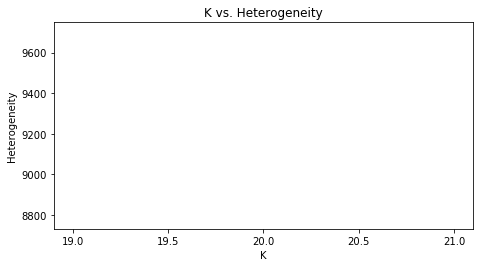

In [226]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

centroids = {}
cluster_assignment = {}
heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#k_list = range(2,100) ## SELECTED 20 clusters post analysis of data
k_list = [20]
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(stock_data_features, k, maxiter=400,
                                                               num_runs=len(seed_list),
                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(stock_data_features, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In [227]:
print (np.bincount(cluster_assignment[20]))

[1540  155   35  206   19   16   98   95   85   71  141   94   29   65   54
   16  124   15   96   72]


In [228]:
distances = pairwise_distances(stock_data_features,centroids[20], metric='euclidean')

In [229]:
distances[0]

array([ 0.14713632,  6.38253992,  6.16229483,  2.24641921,  7.58205346,
        7.74596669,  7.43895048,  4.66802645,  5.75767879,  5.74084922,
        5.50626441,  4.65218495,  9.12230284,  6.97676618,  7.22727743,
        7.08927447,  4.56079582,  7.00412577,  4.15572783,  7.30147488])

In [230]:
stock_data_features[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [231]:
cluster_assign = np.argmin(distances,axis=1)

In [232]:
cluster_assign

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [233]:
cluster_nbr = pd.Series(list(cluster_assign))

In [234]:
pd_stock_data['Cluster#'] = cluster_nbr

In [235]:
for i in range(20):
    print (str(sum(pd_stock_data['Cluster#']==i)))

1540
155
35
206
19
16
98
95
85
71
141
94
29
65
54
16
124
15
96
72


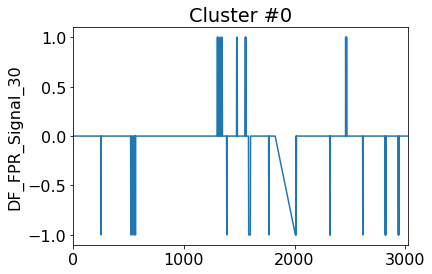

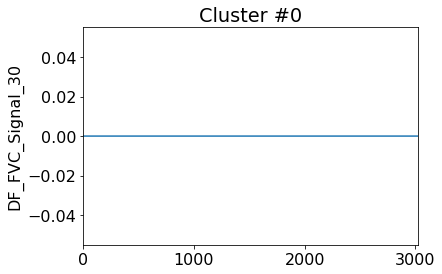

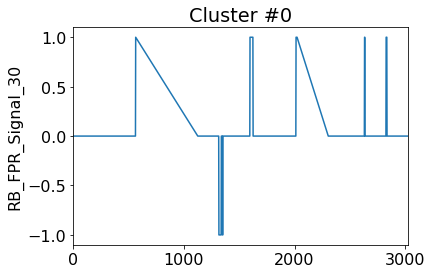

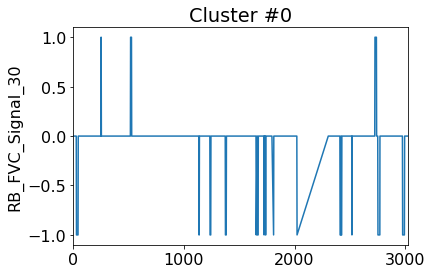

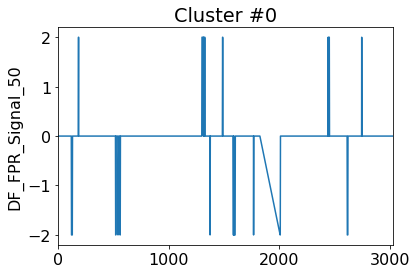

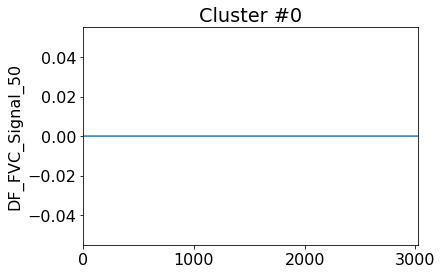

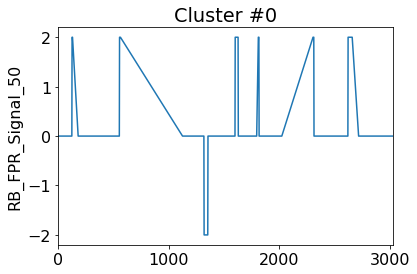

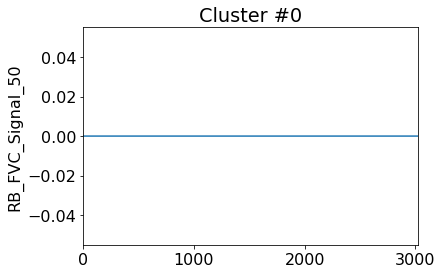

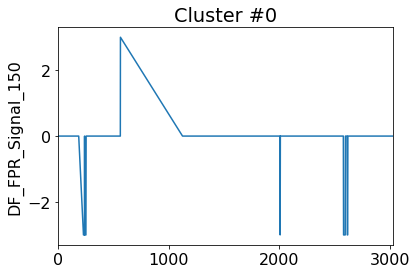

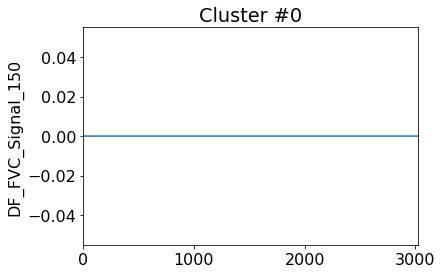

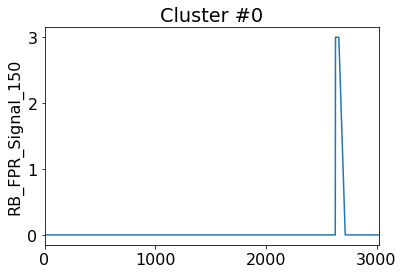

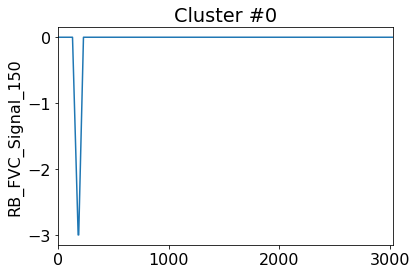

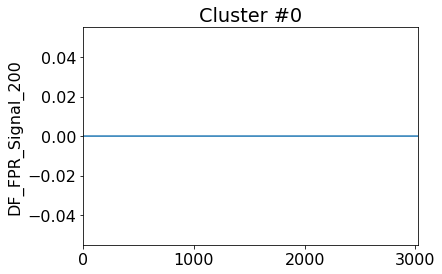

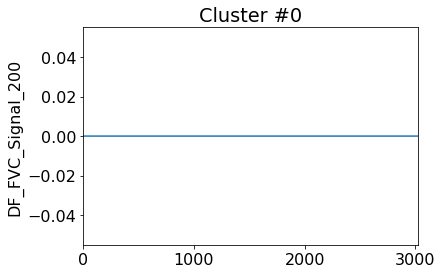

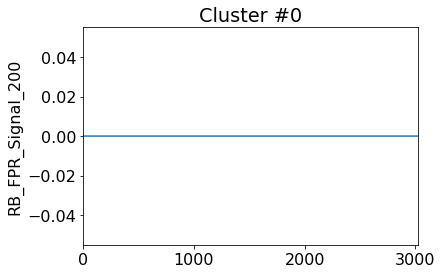

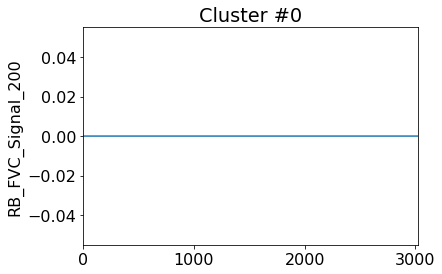

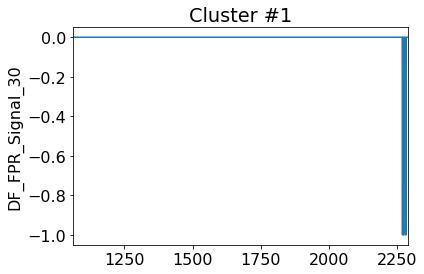

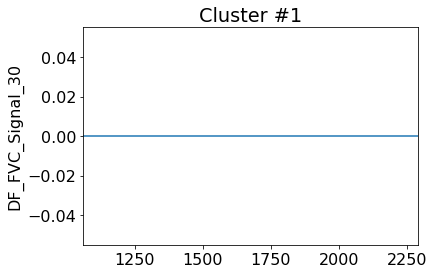

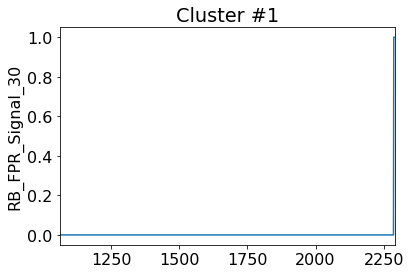

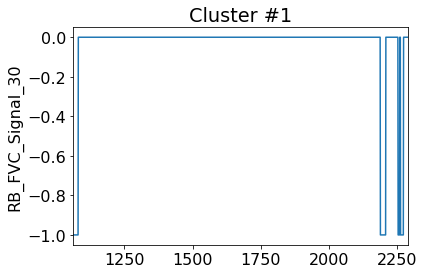

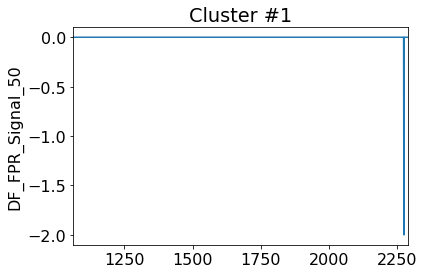

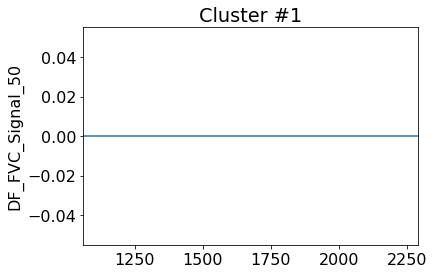

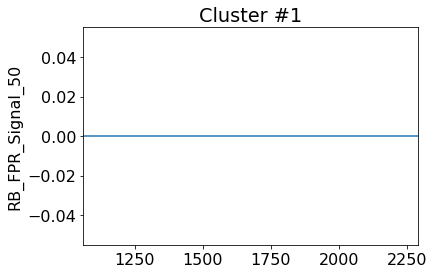

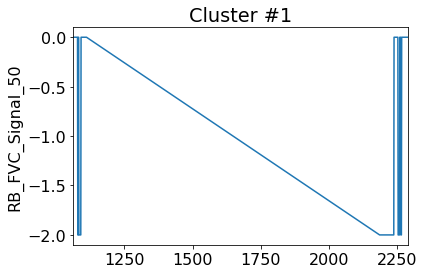

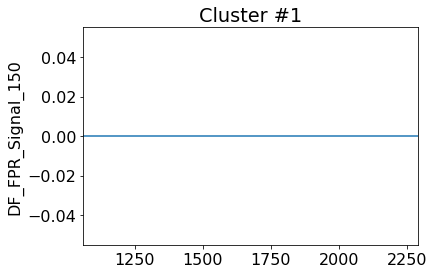

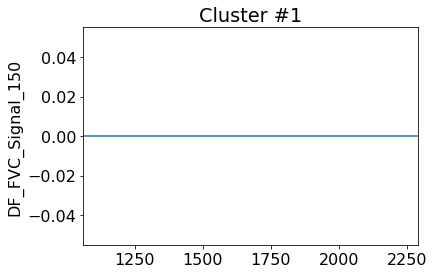

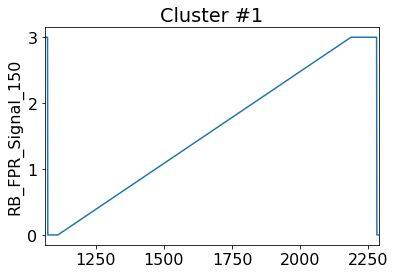

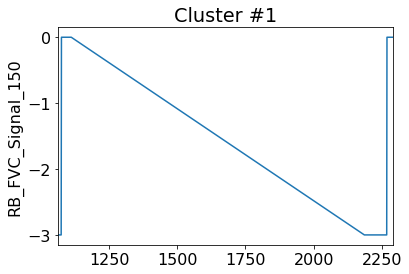

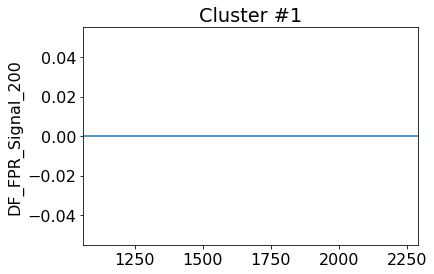

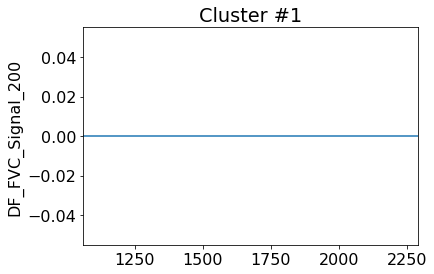

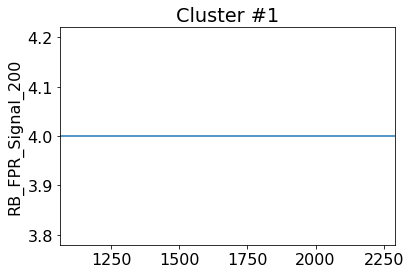

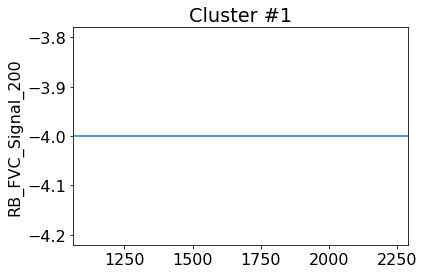

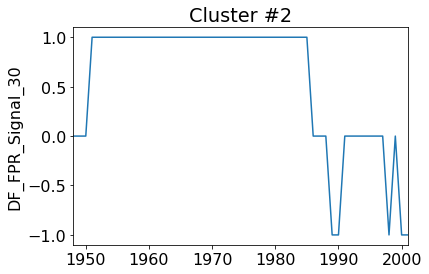

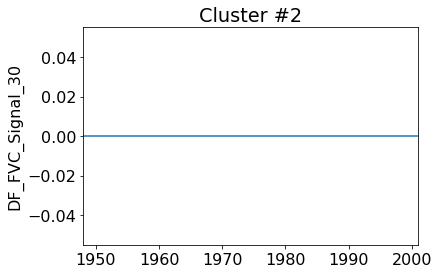

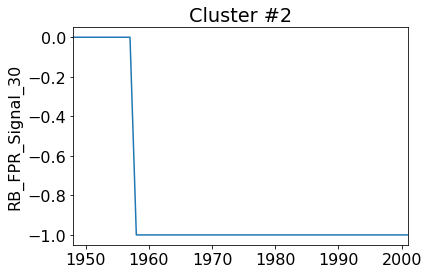

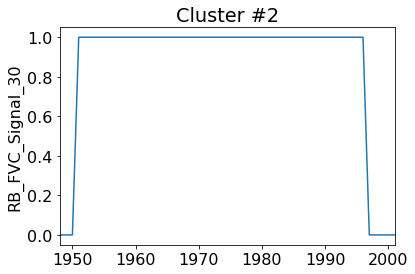

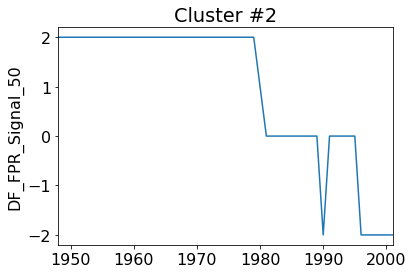

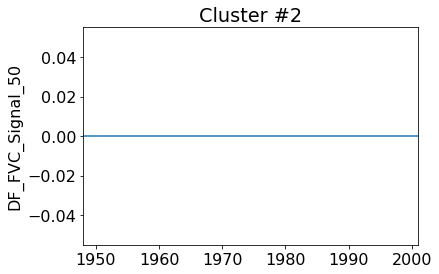

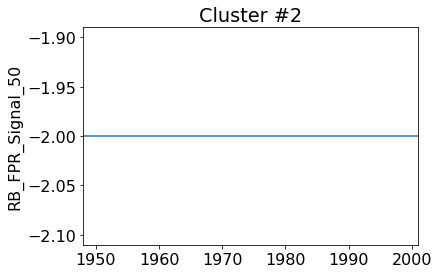

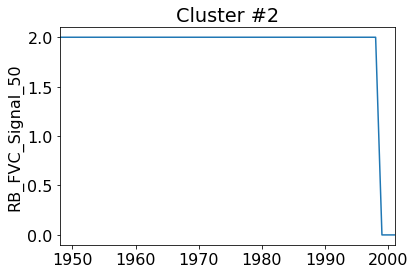

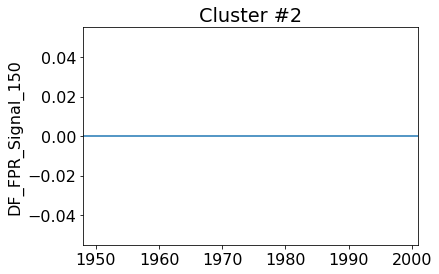

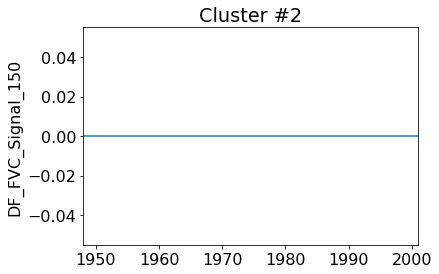

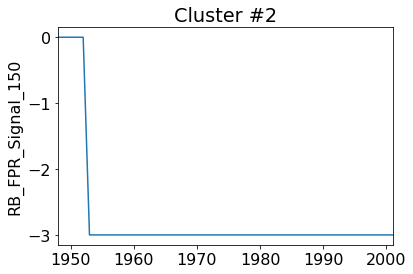

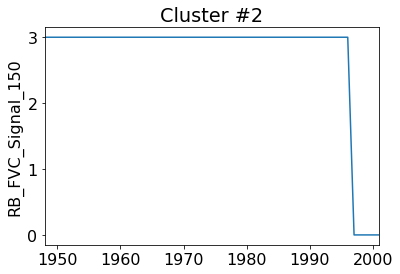

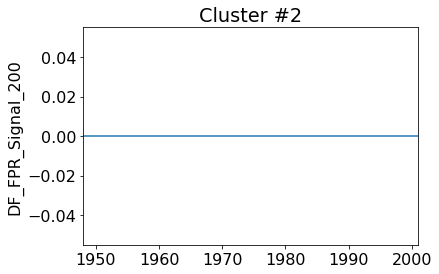

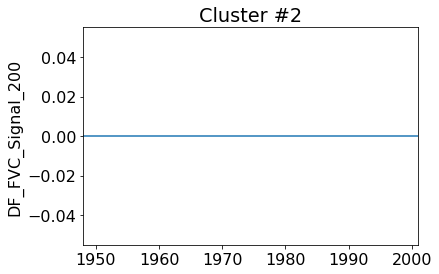

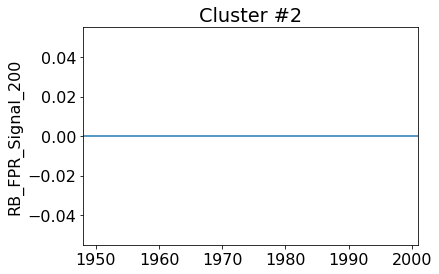

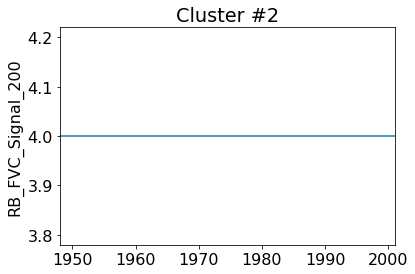

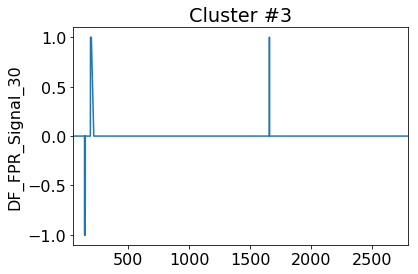

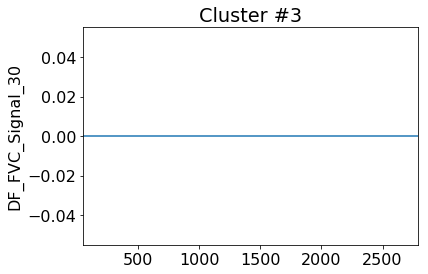

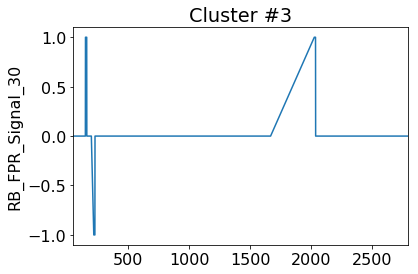

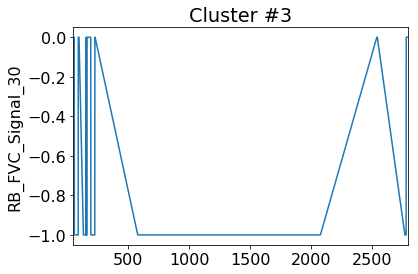

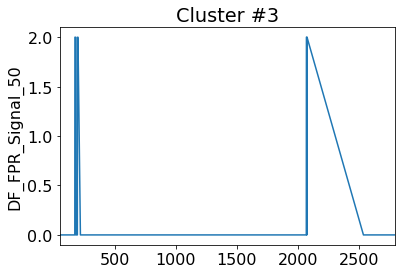

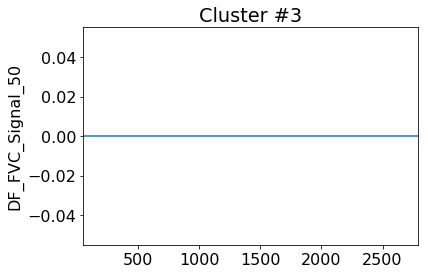

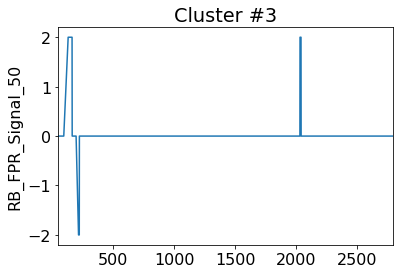

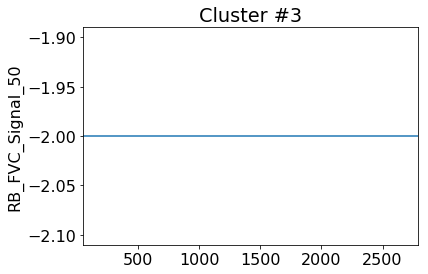

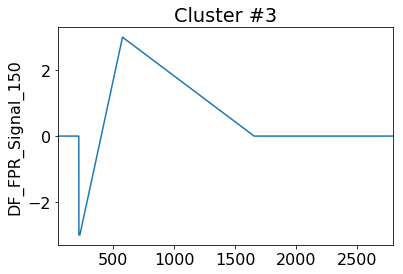

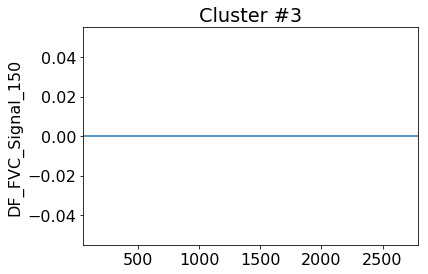

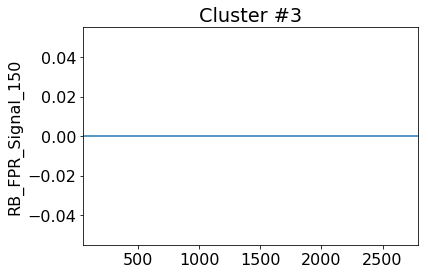

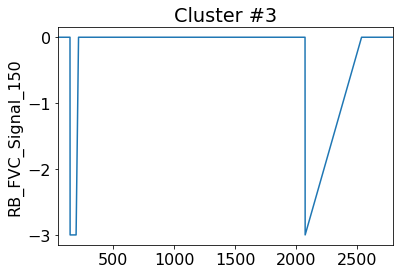

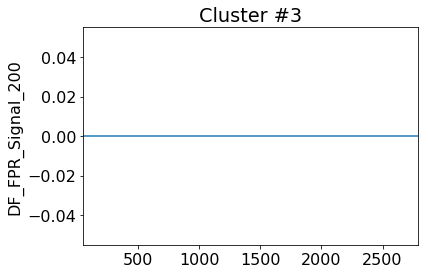

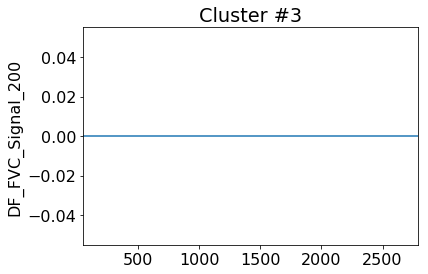

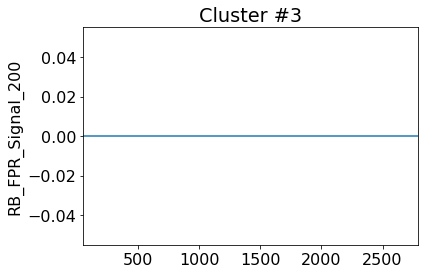

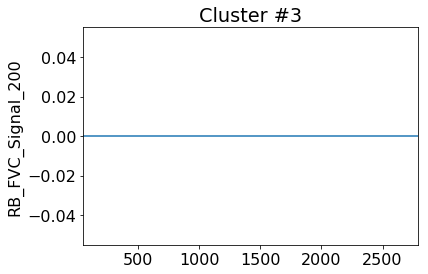

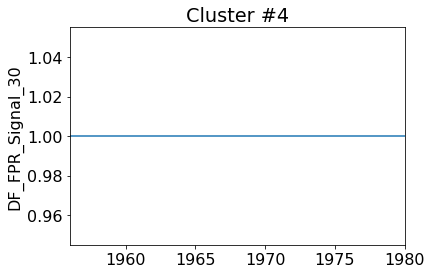

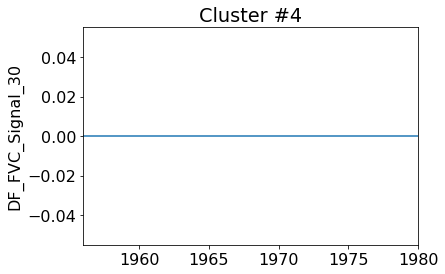

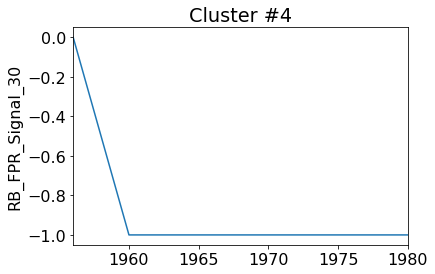

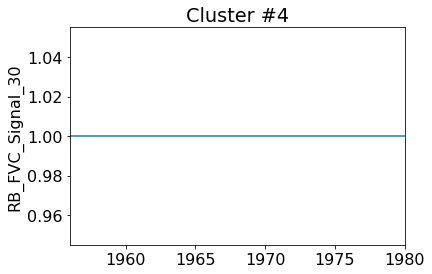

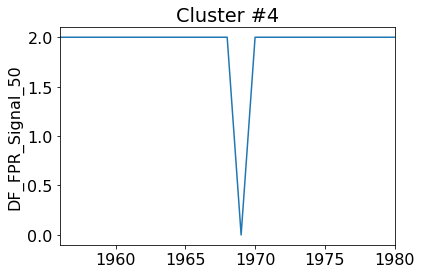

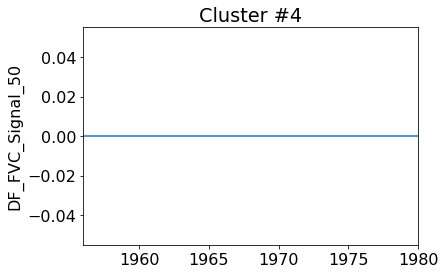

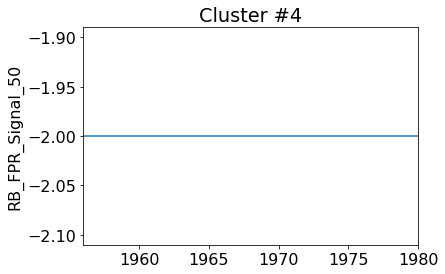

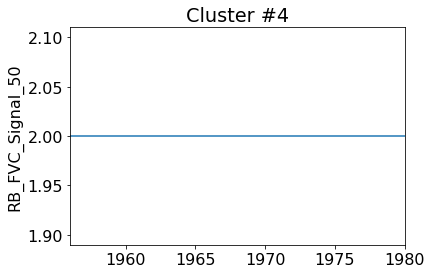

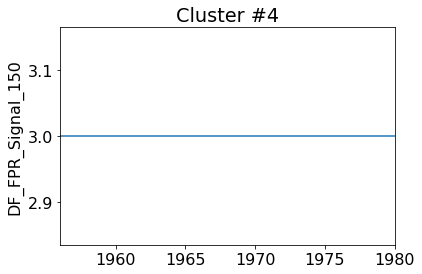

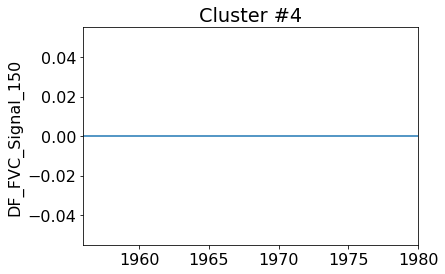

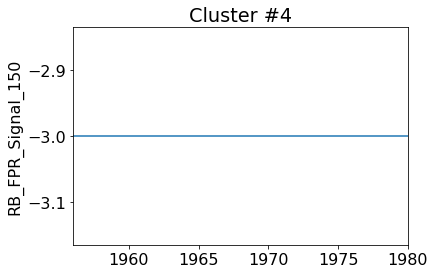

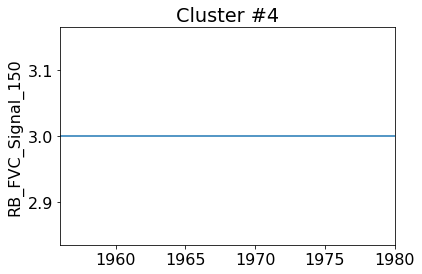

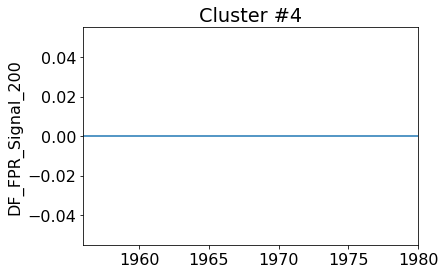

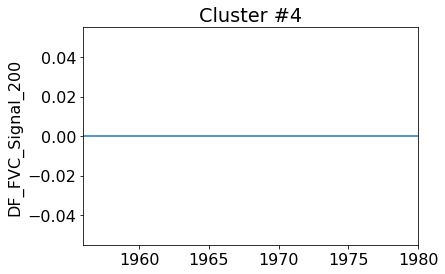

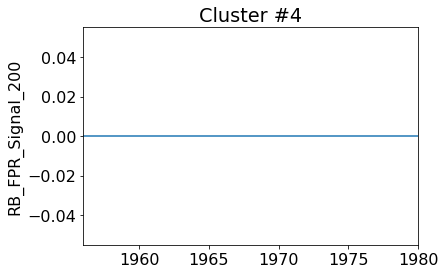

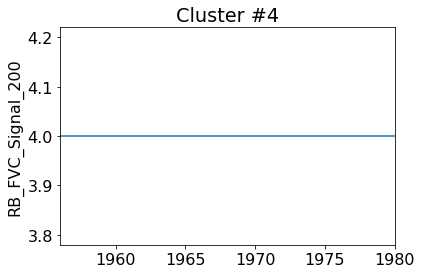

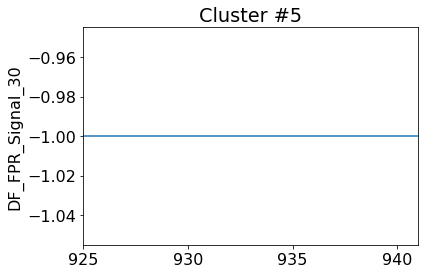

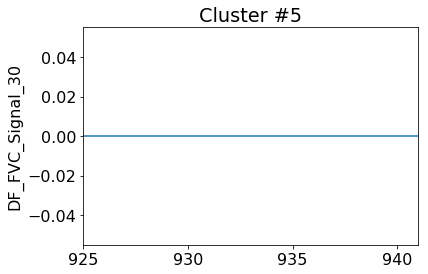

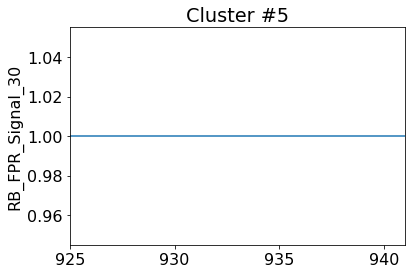

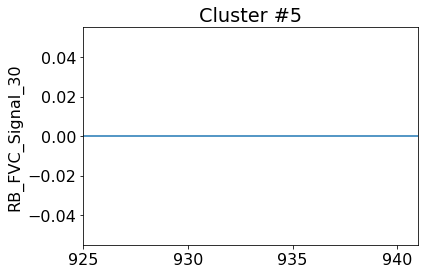

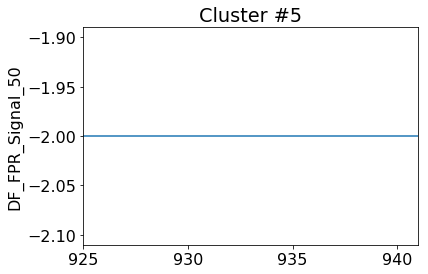

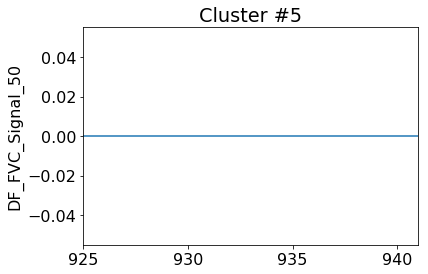

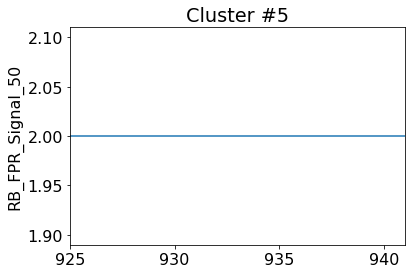

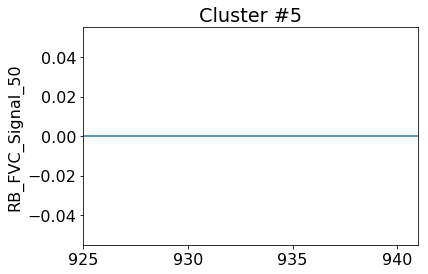

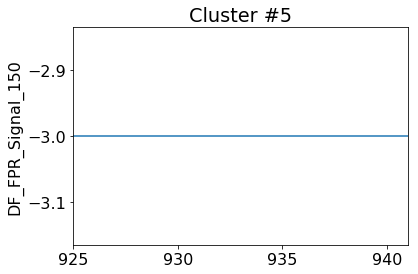

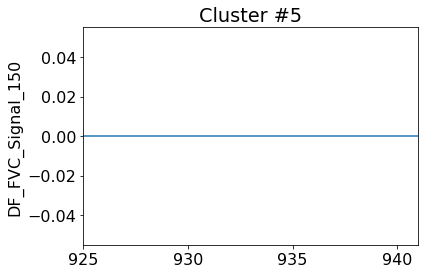

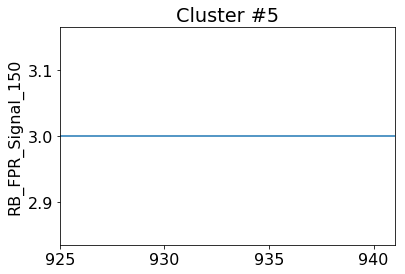

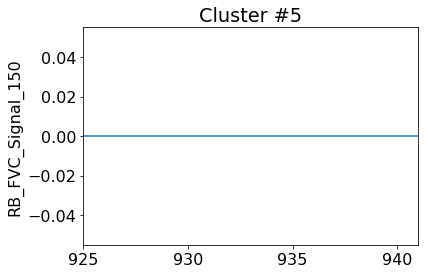

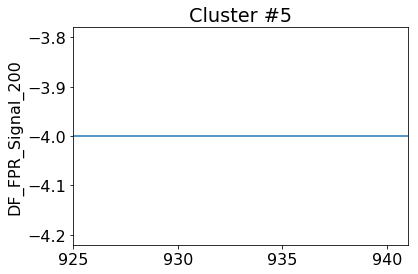

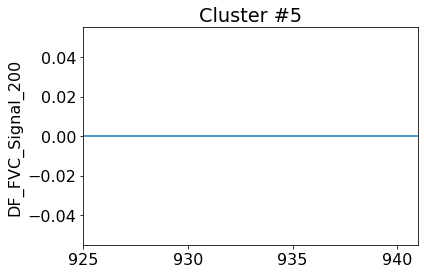

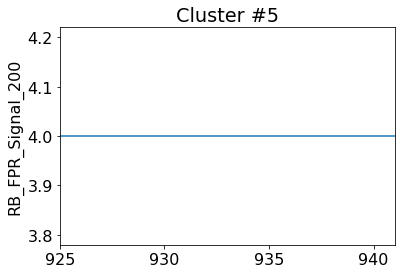

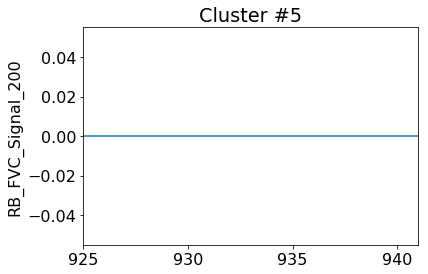

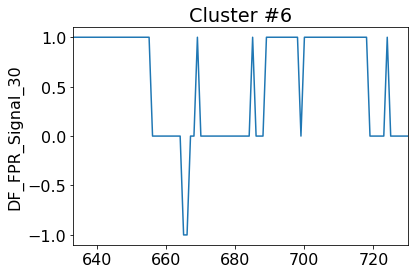

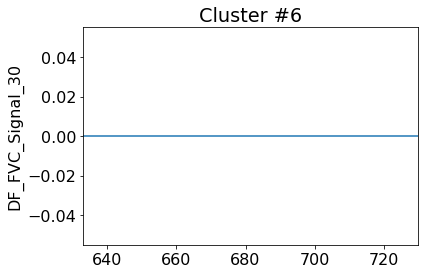

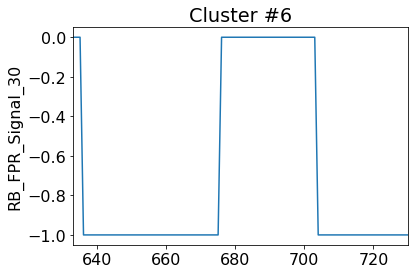

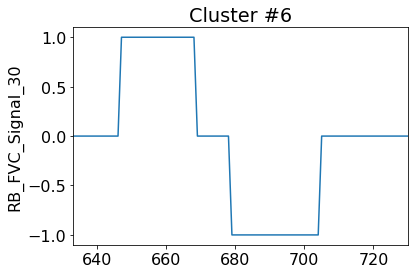

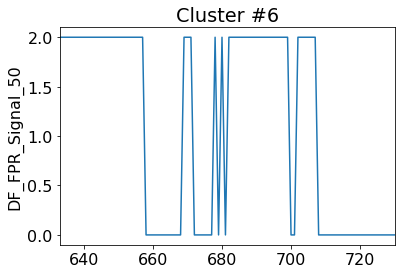

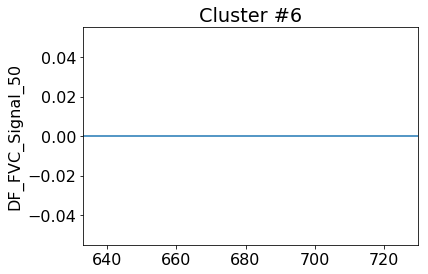

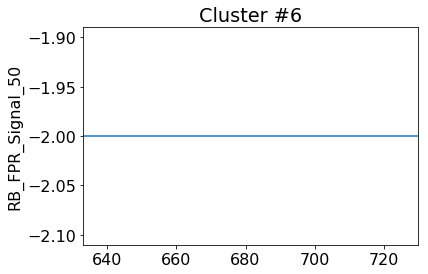

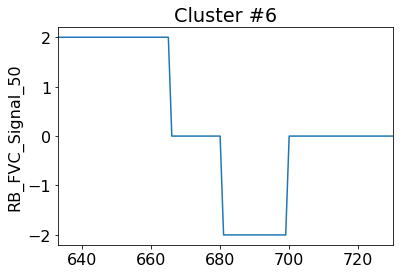

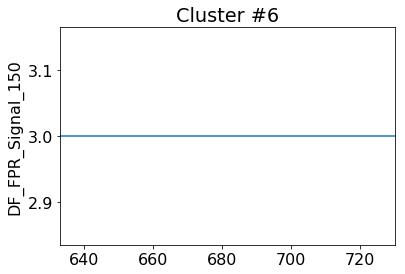

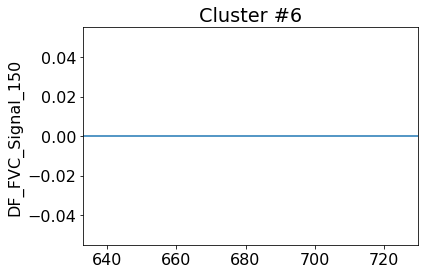

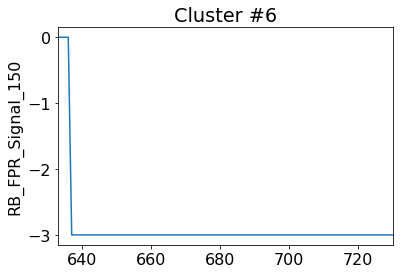

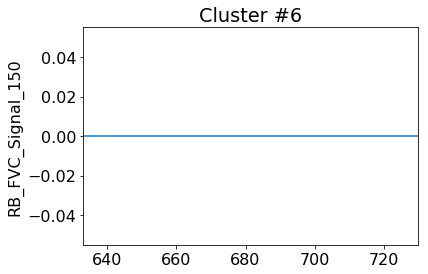

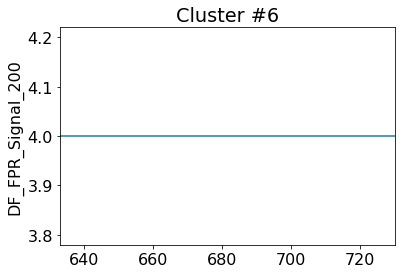

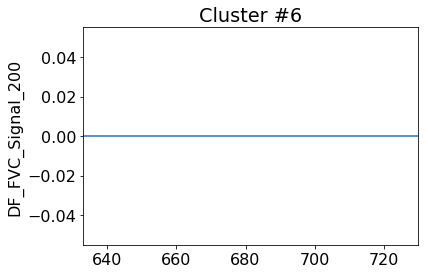

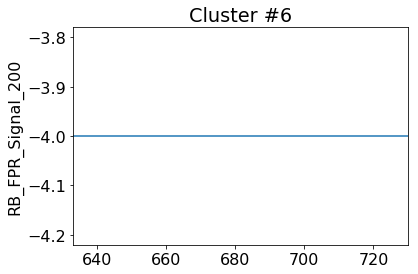

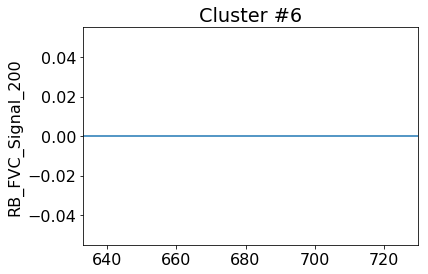

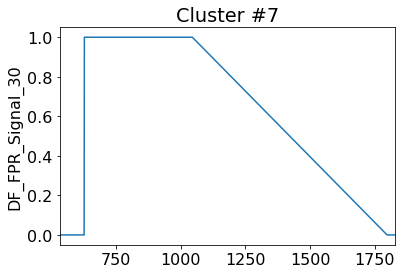

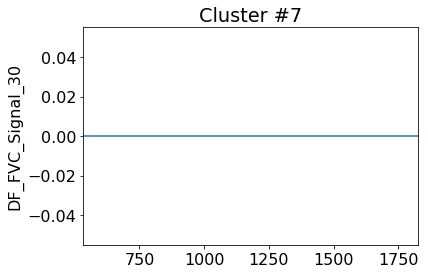

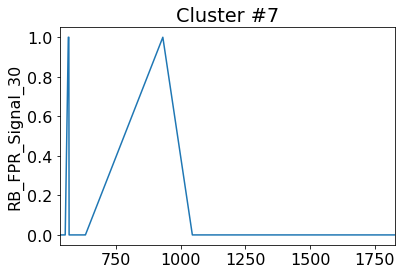

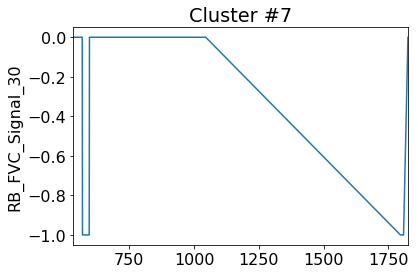

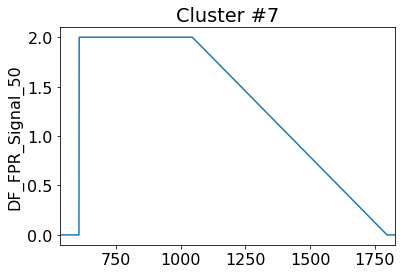

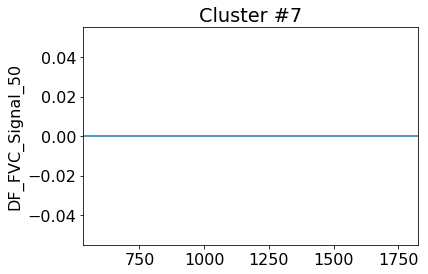

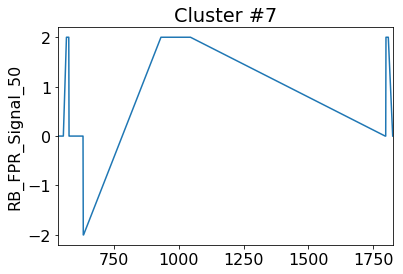

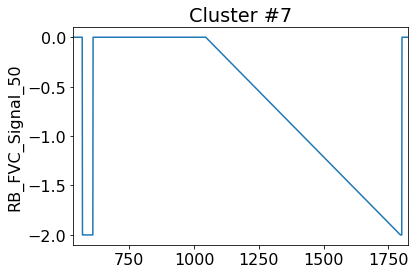

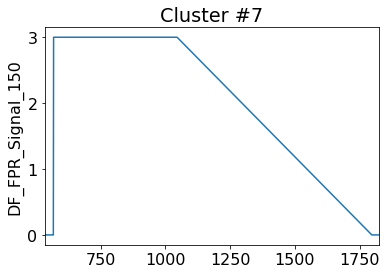

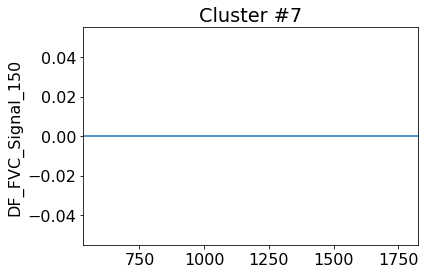

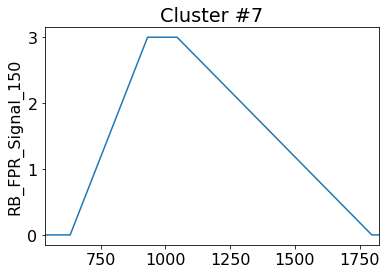

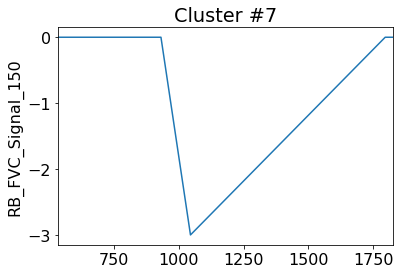

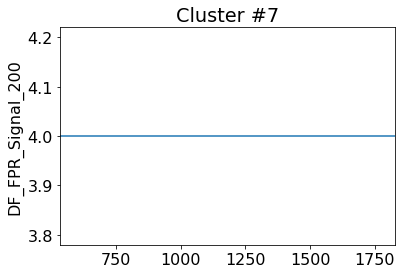

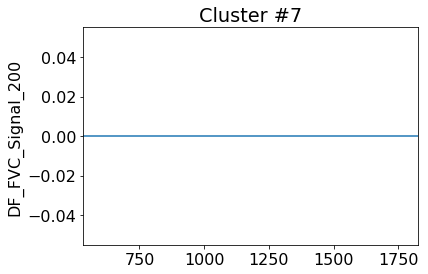

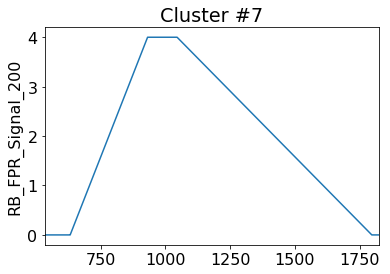

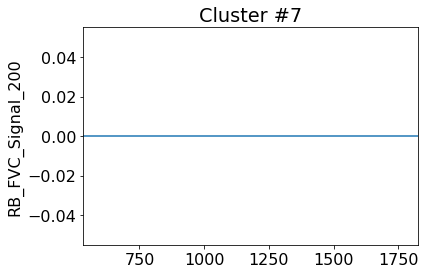

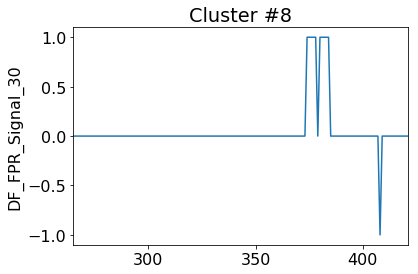

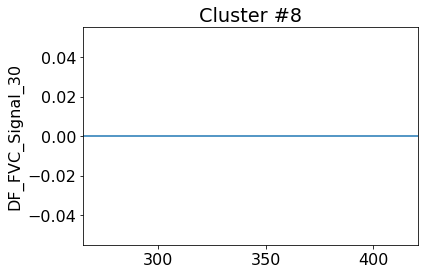

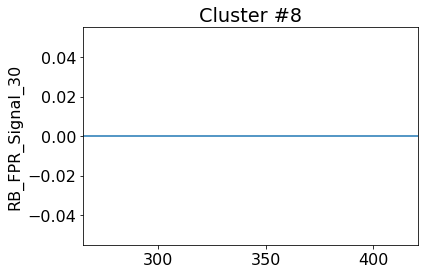

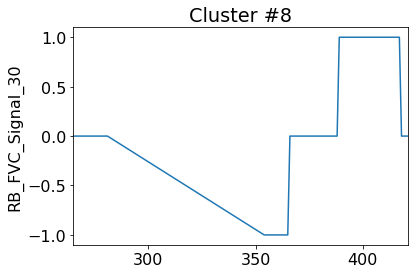

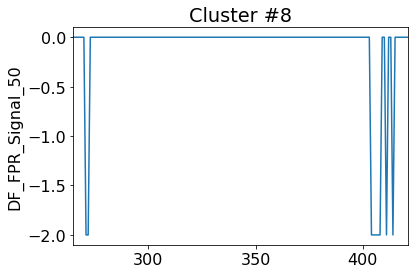

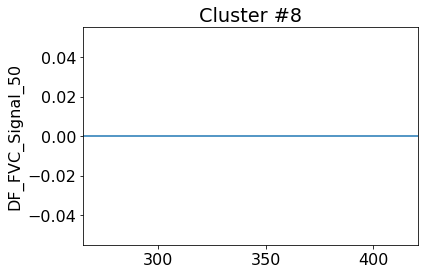

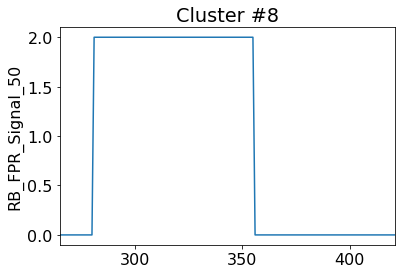

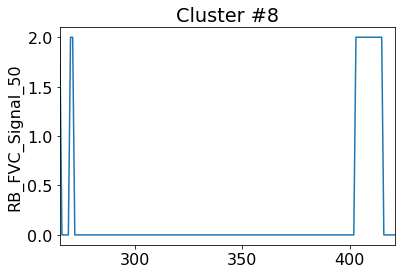

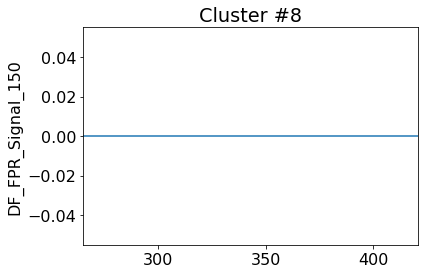

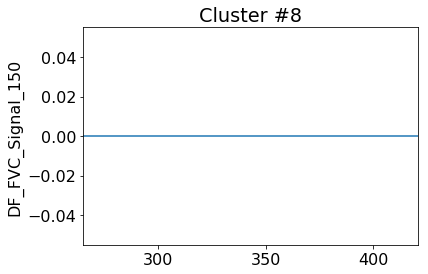

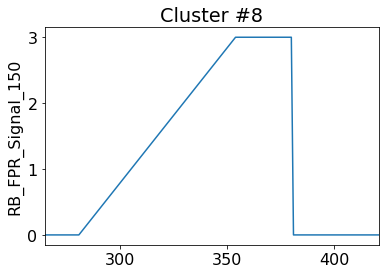

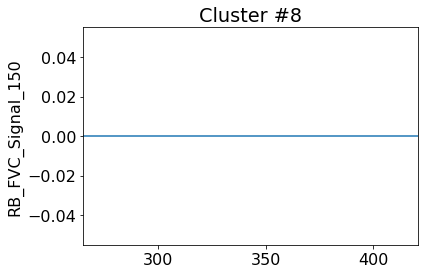

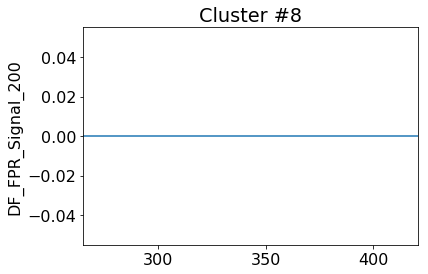

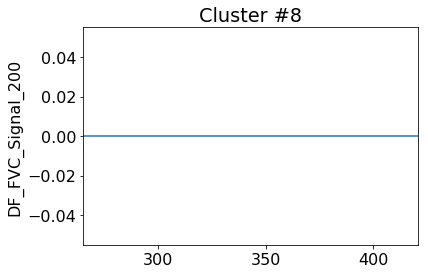

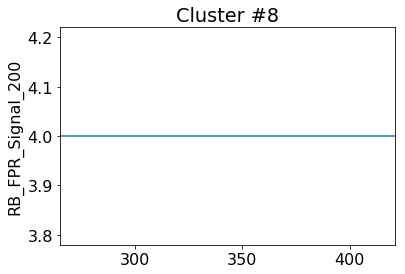

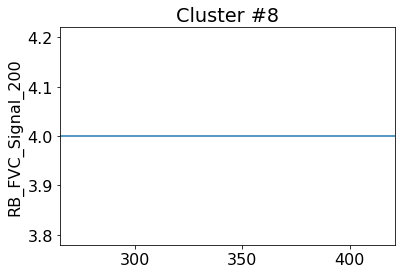

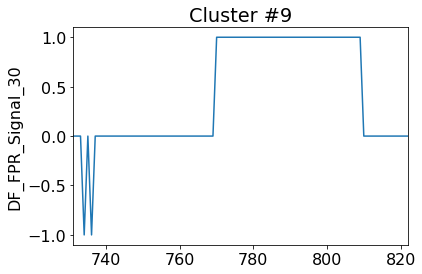

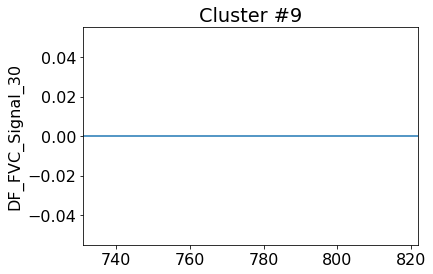

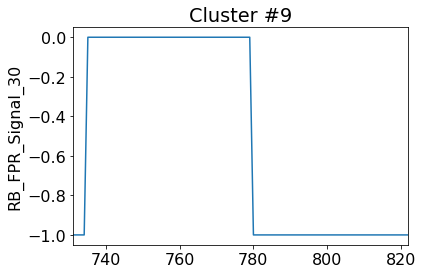

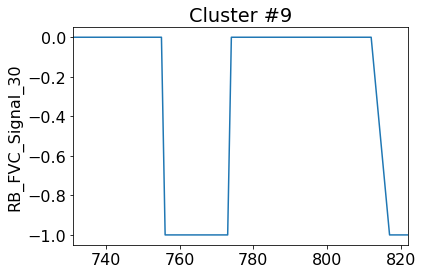

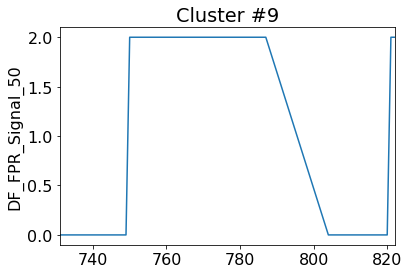

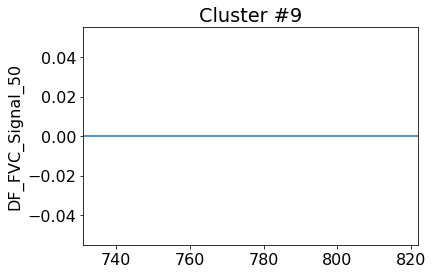

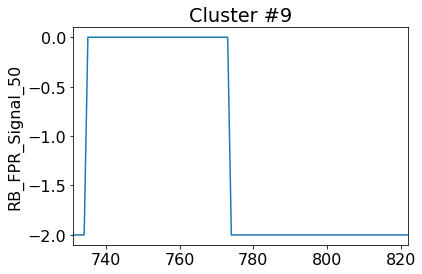

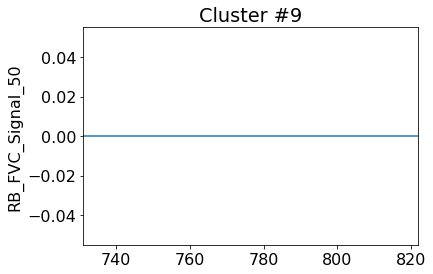

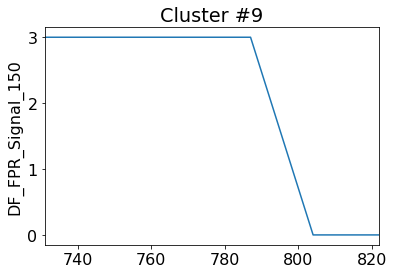

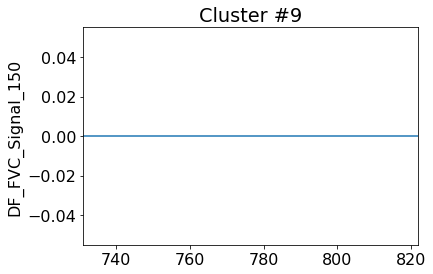

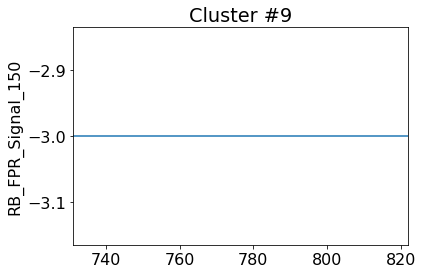

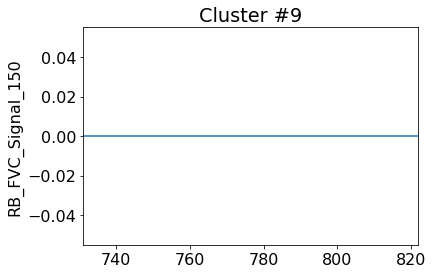

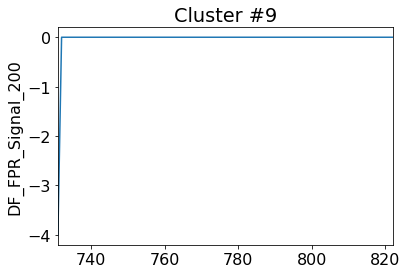

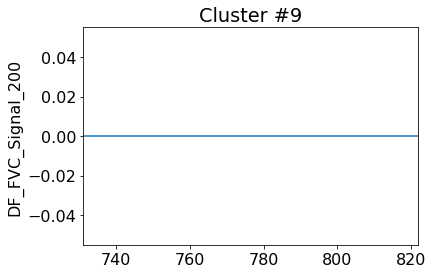

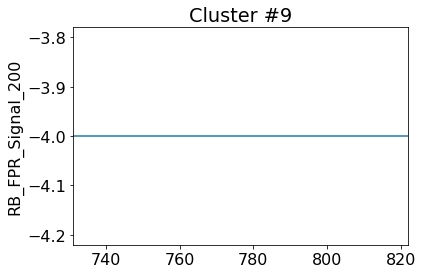

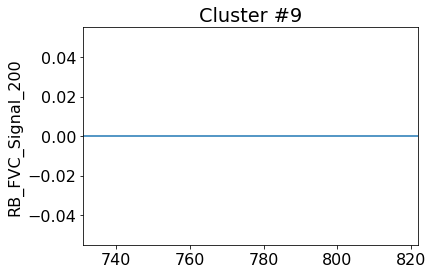

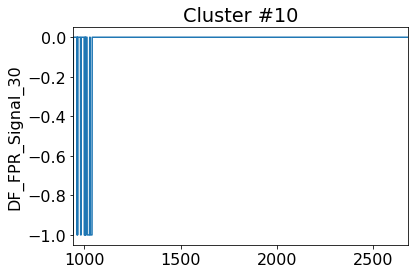

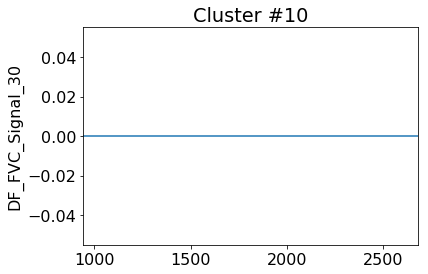

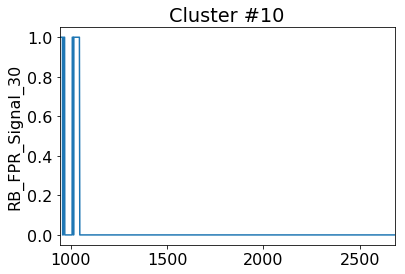

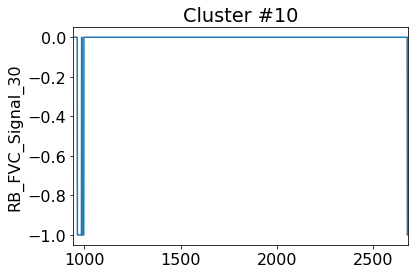

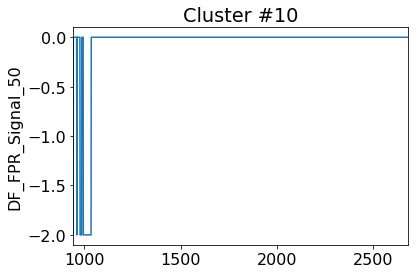

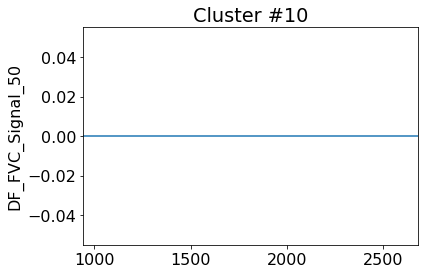

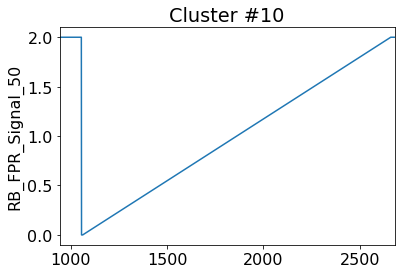

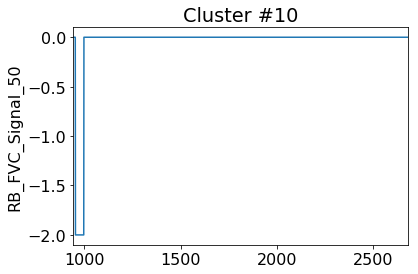

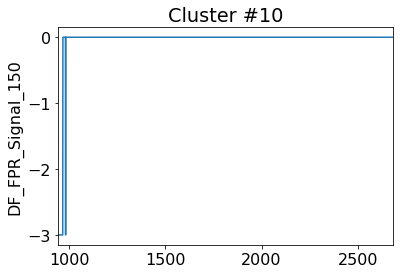

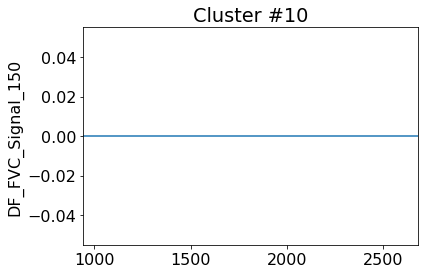

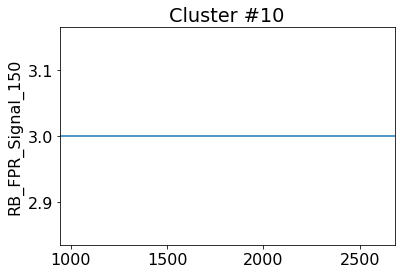

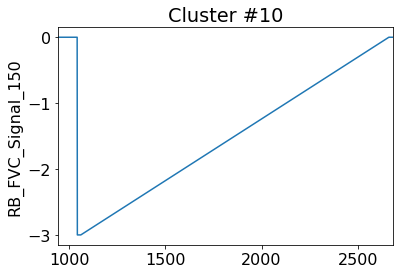

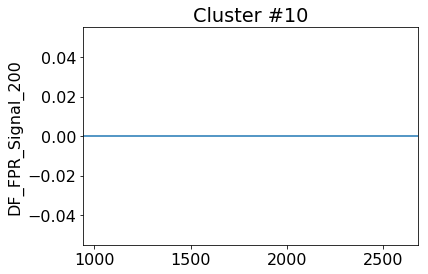

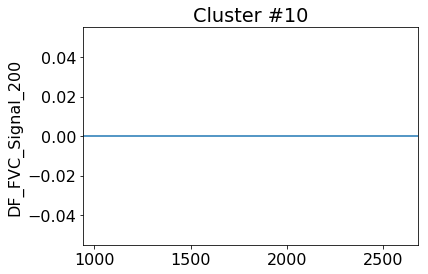

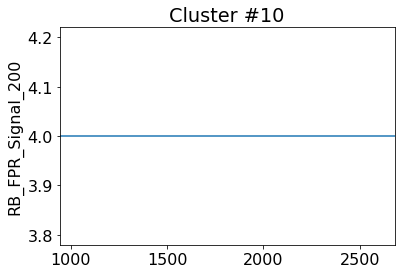

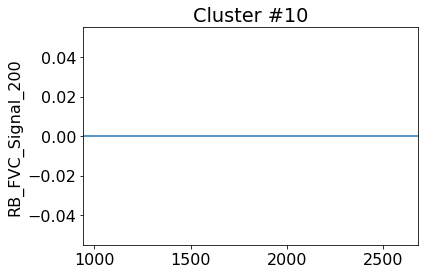

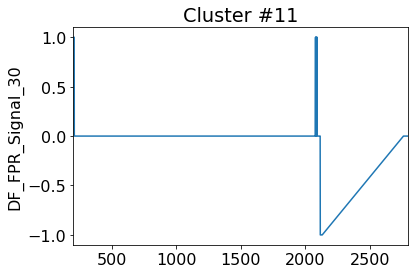

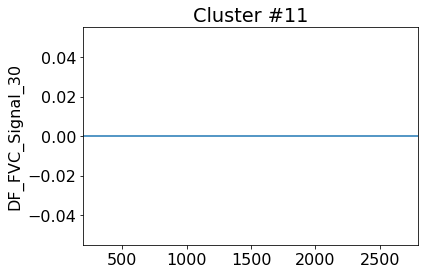

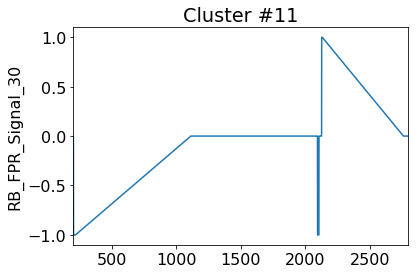

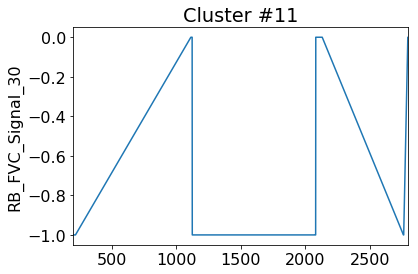

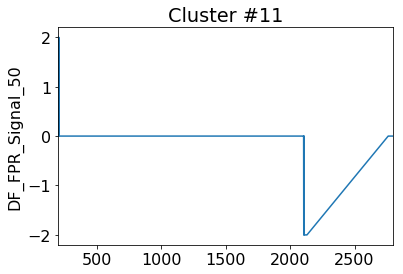

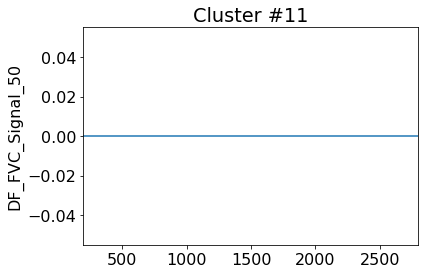

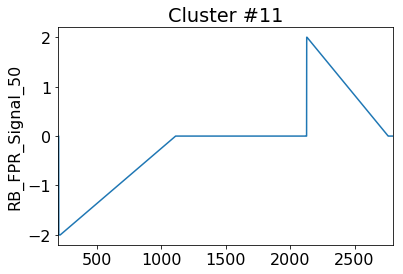

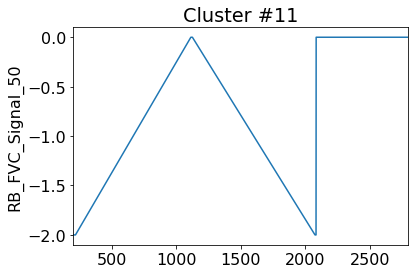

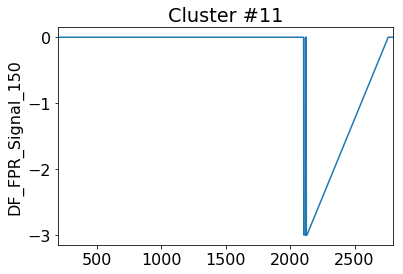

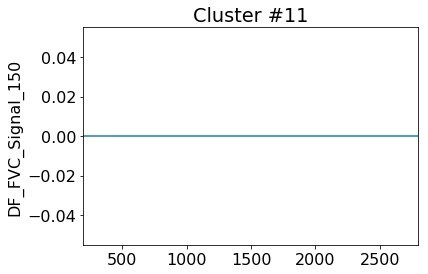

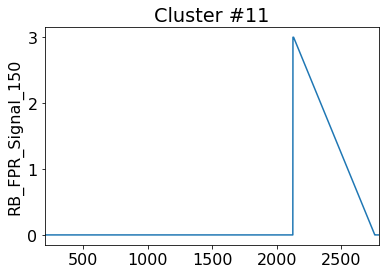

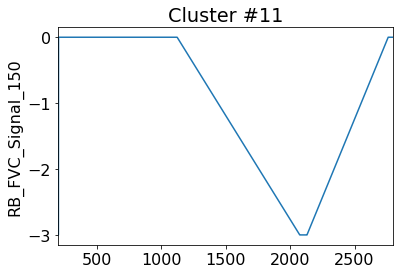

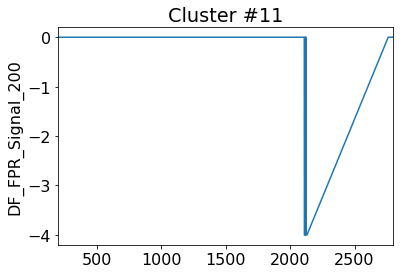

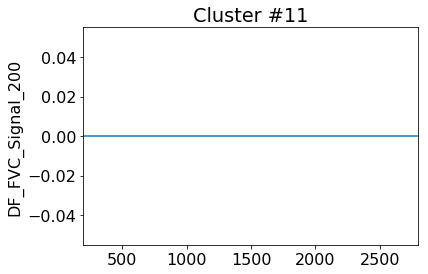

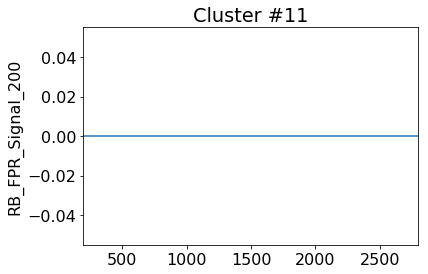

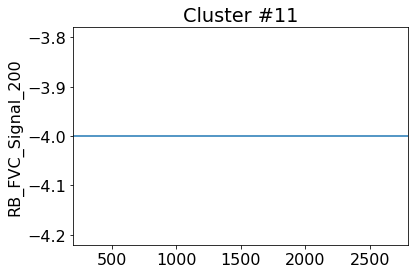

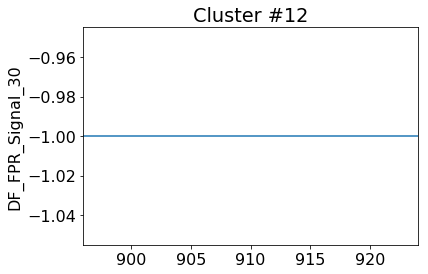

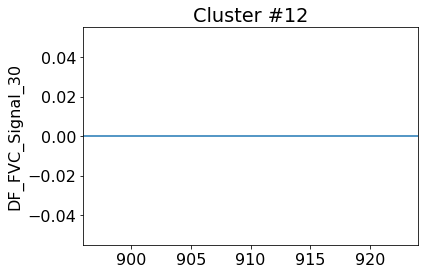

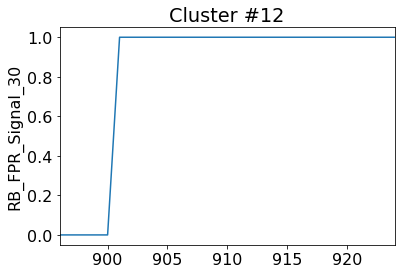

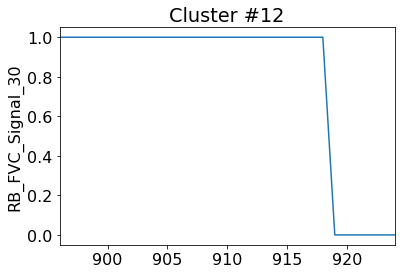

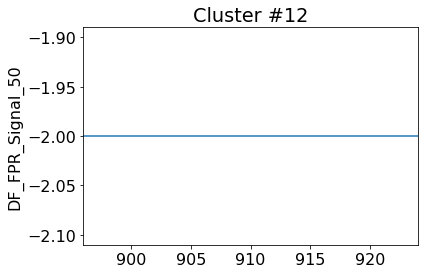

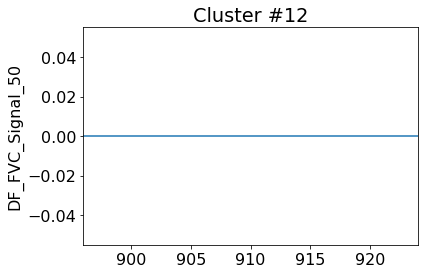

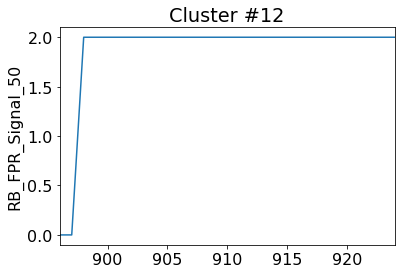

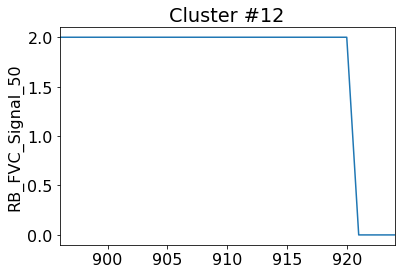

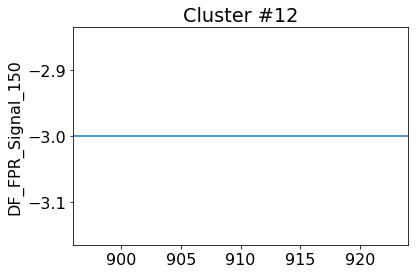

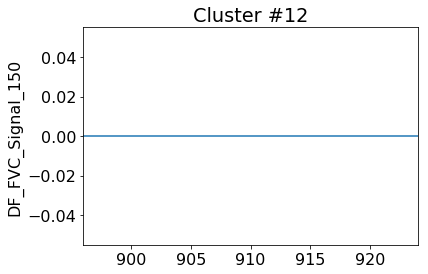

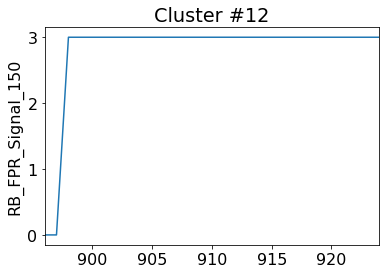

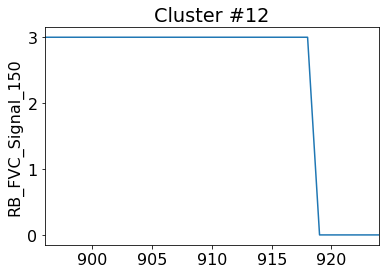

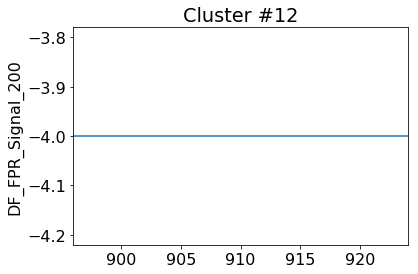

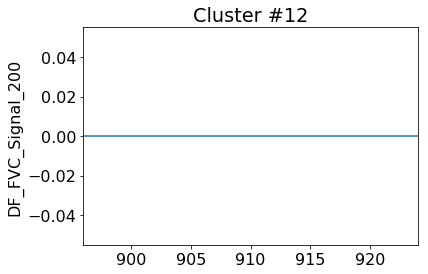

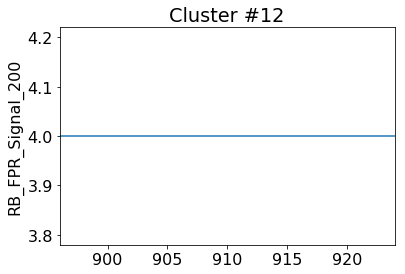

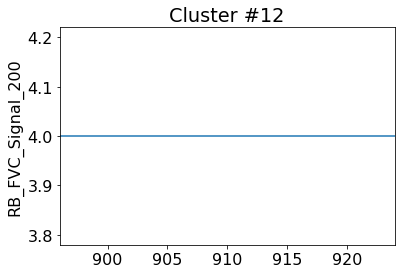

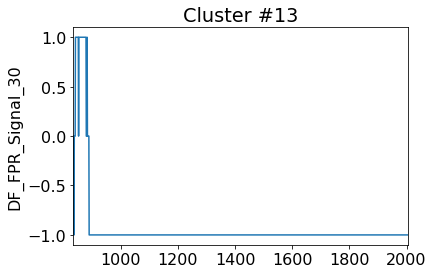

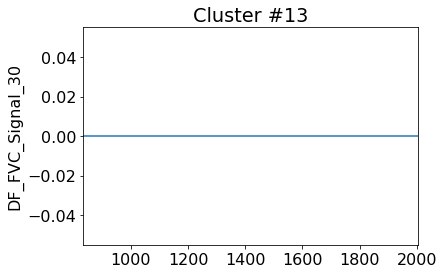

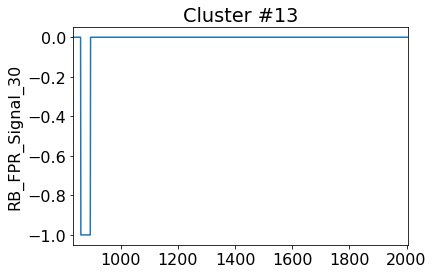

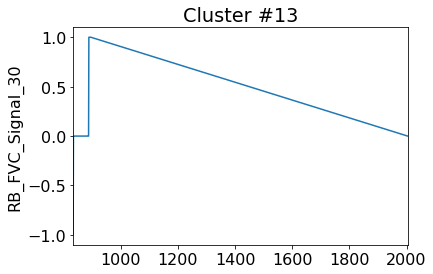

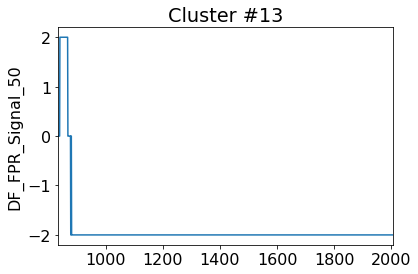

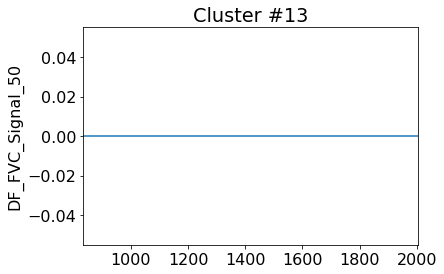

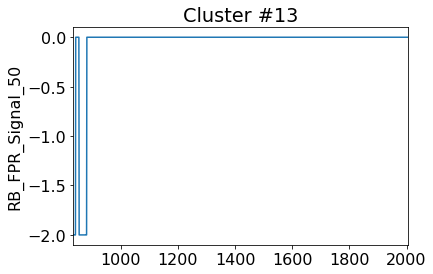

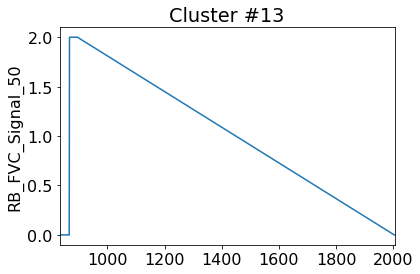

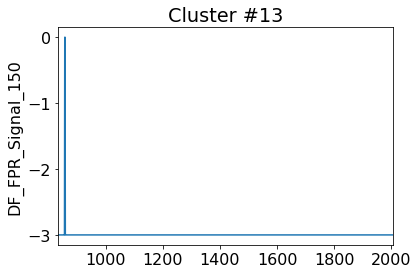

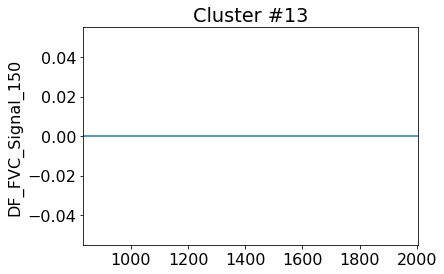

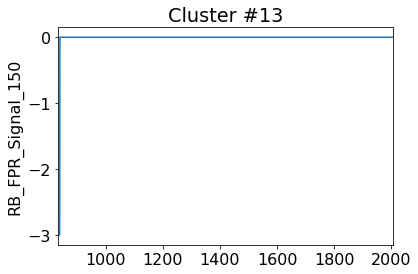

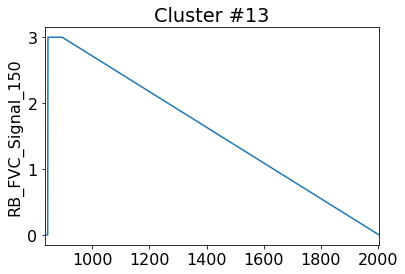

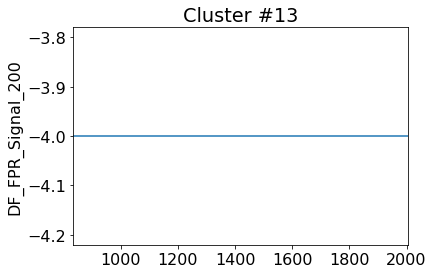

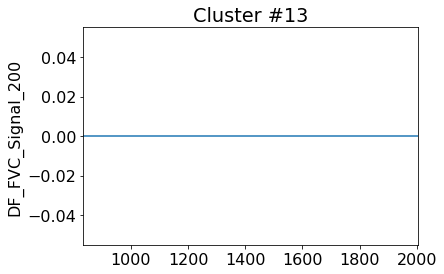

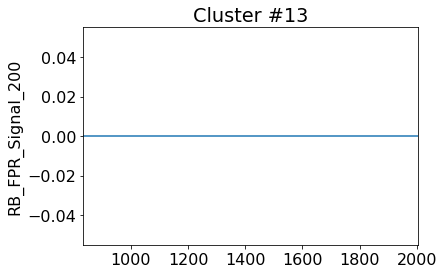

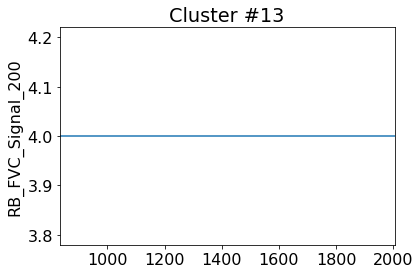

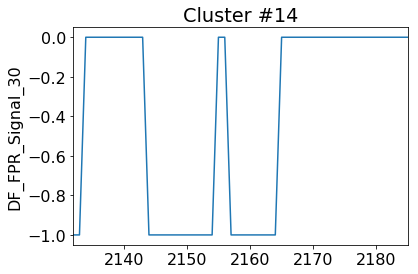

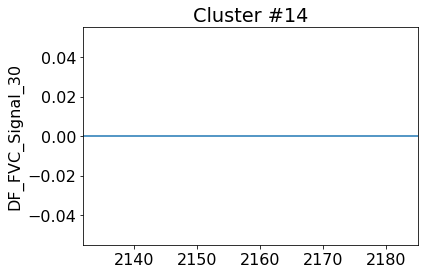

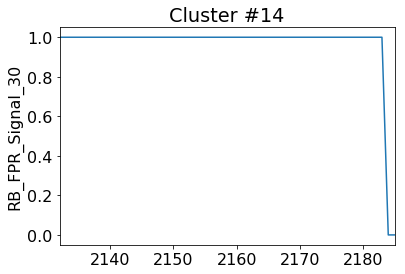

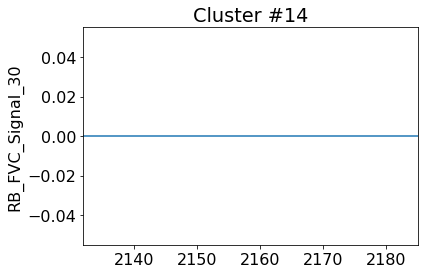

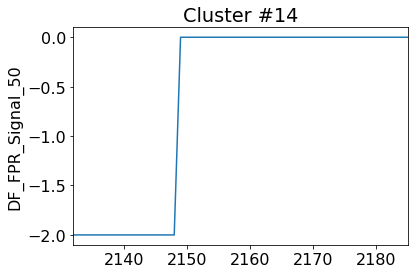

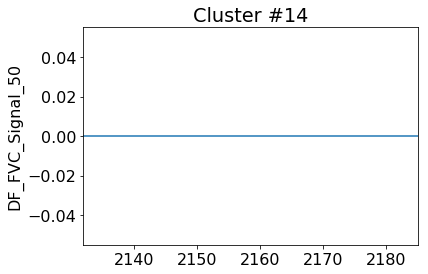

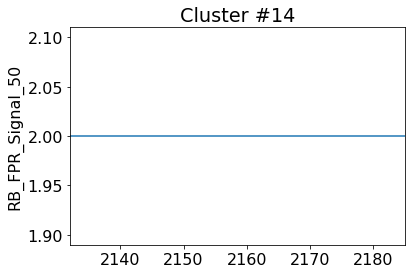

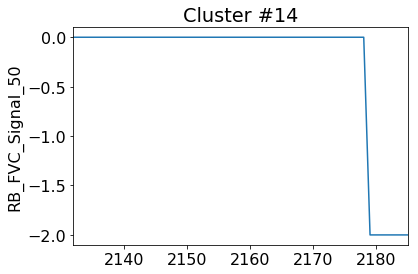

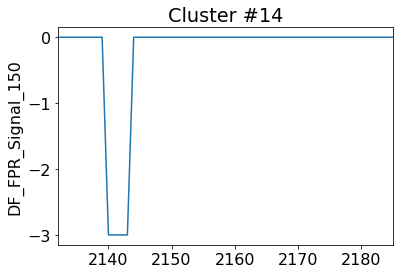

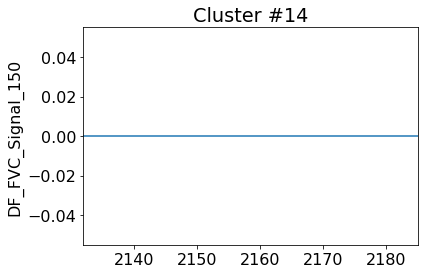

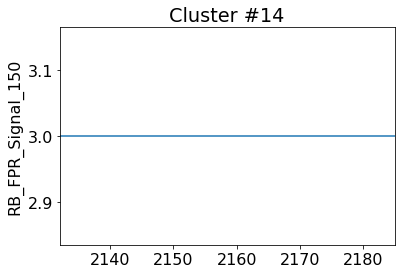

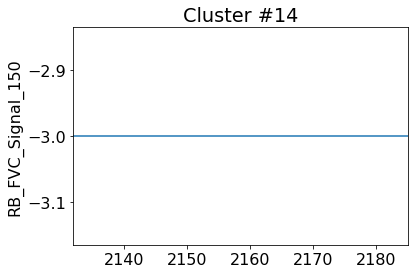

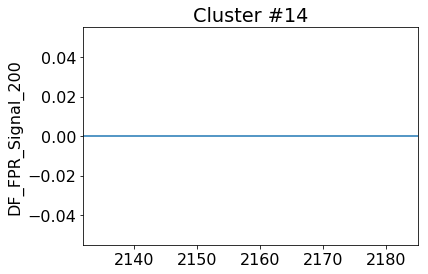

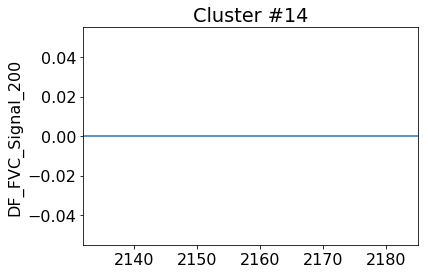

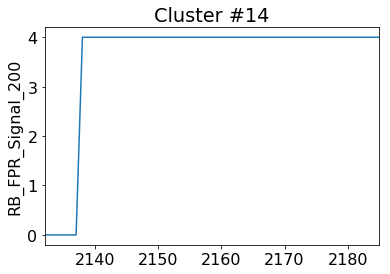

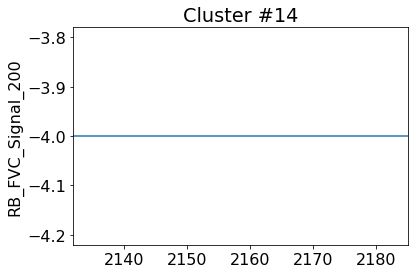

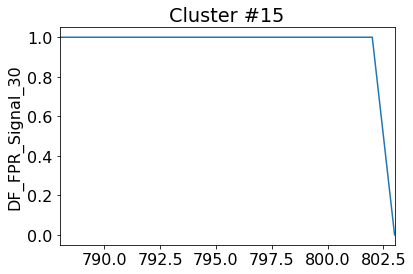

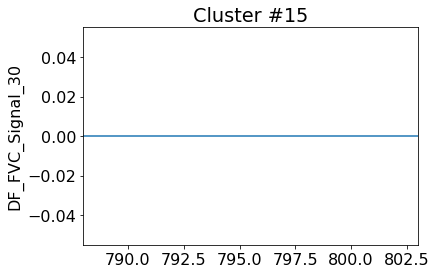

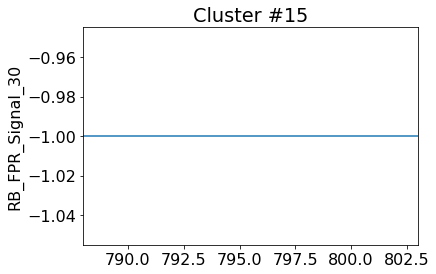

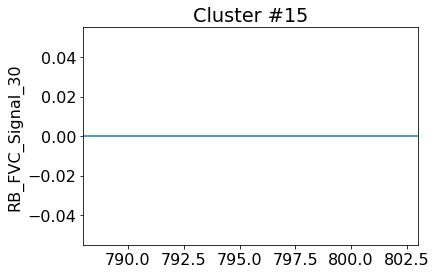

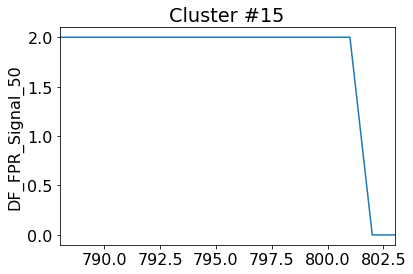

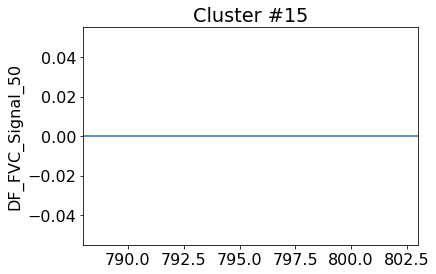

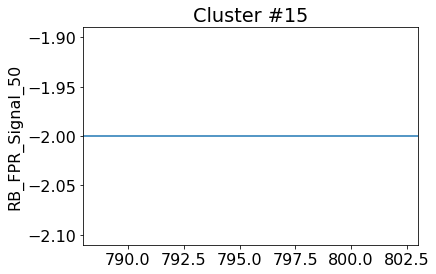

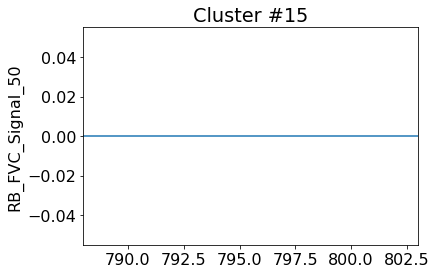

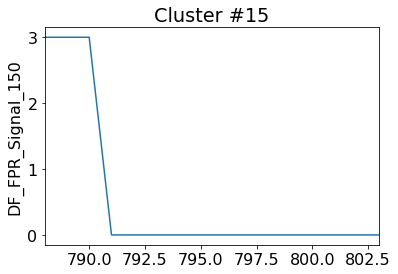

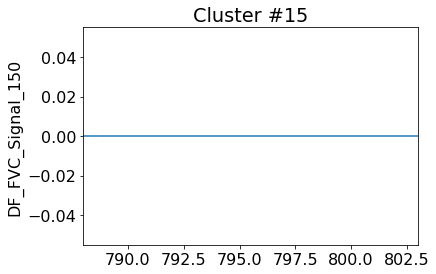

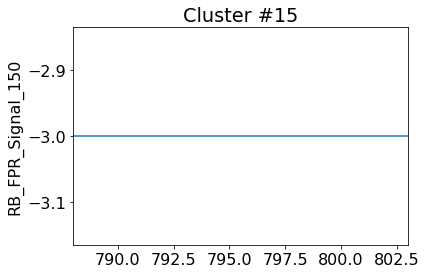

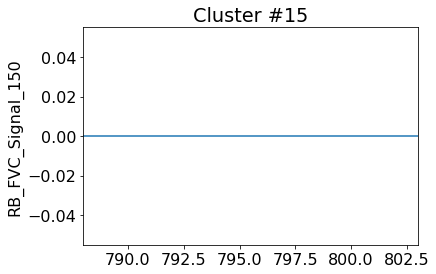

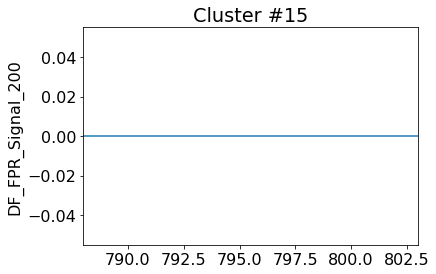

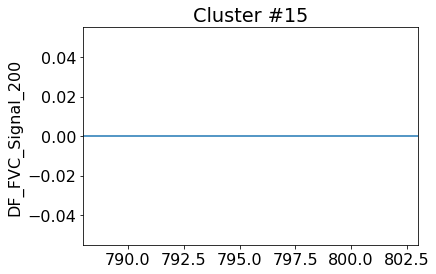

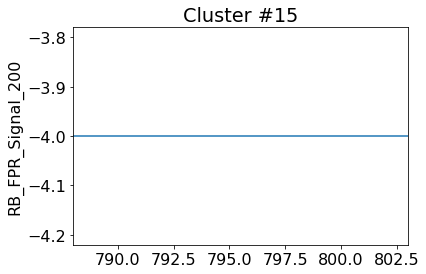

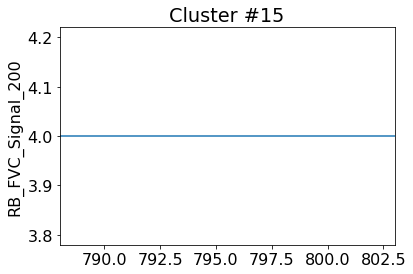

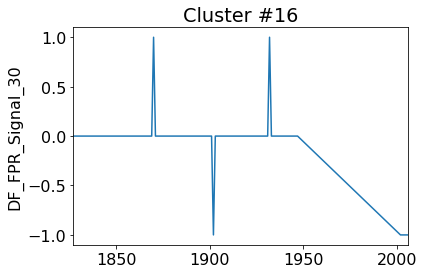

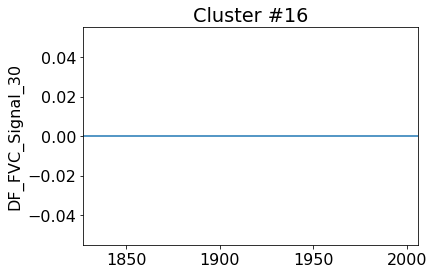

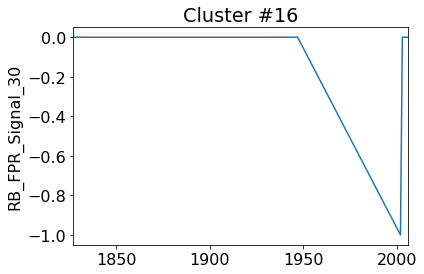

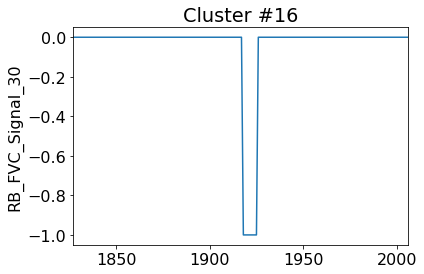

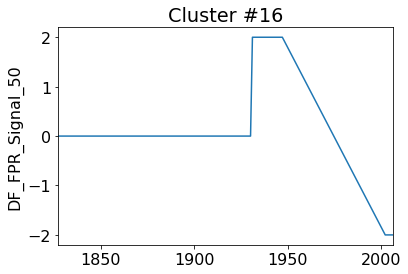

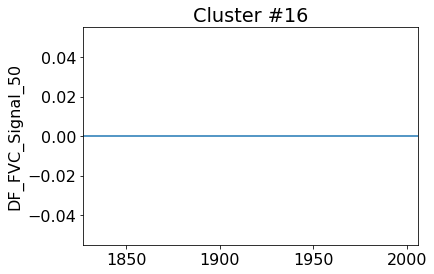

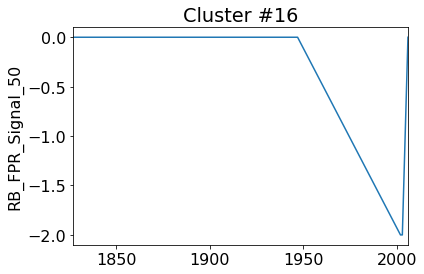

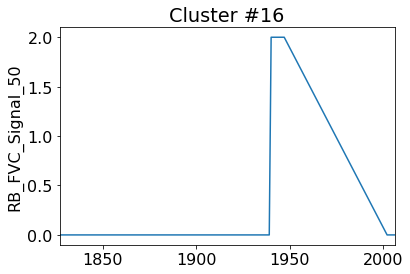

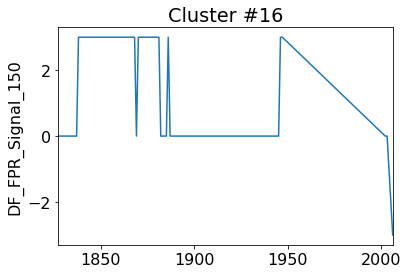

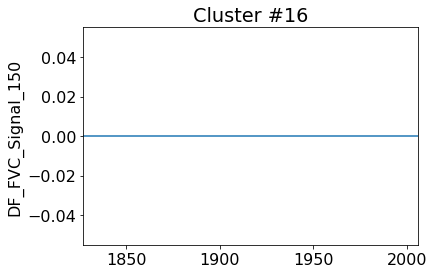

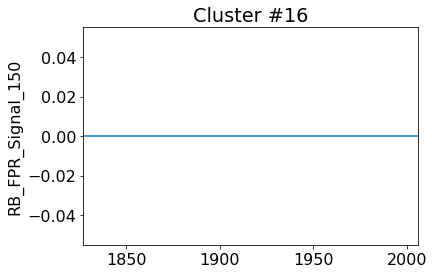

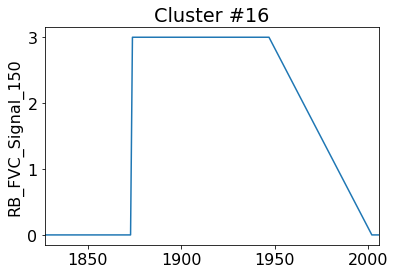

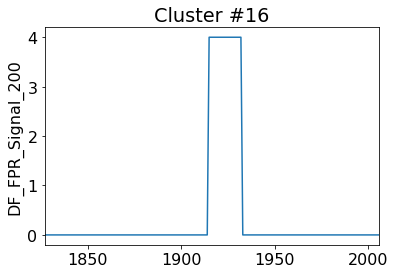

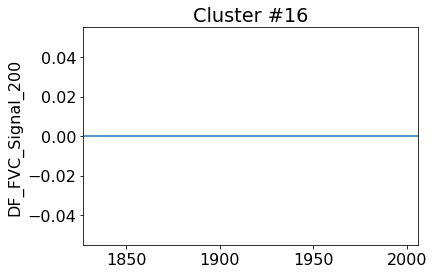

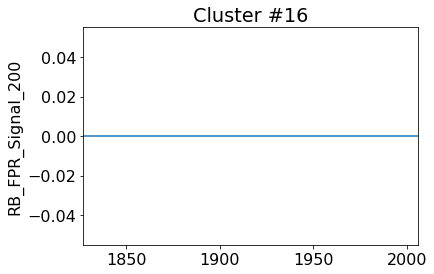

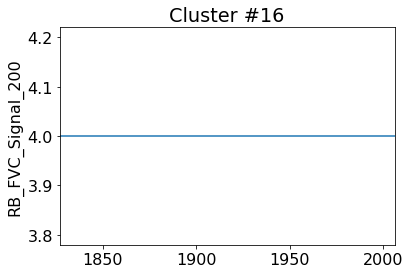

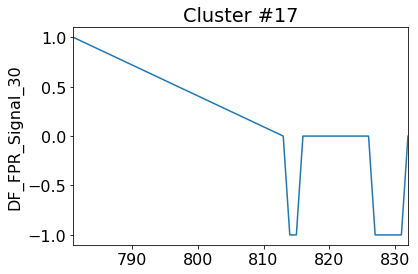

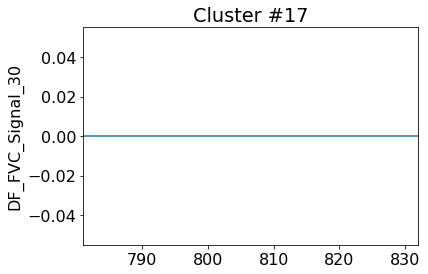

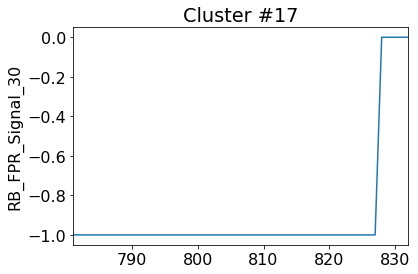

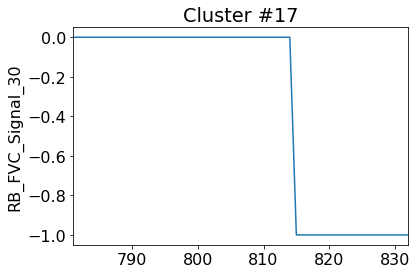

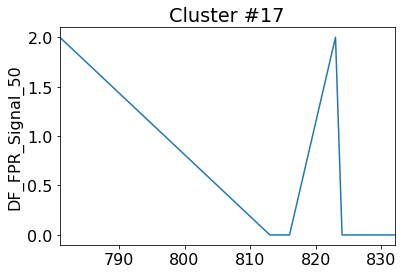

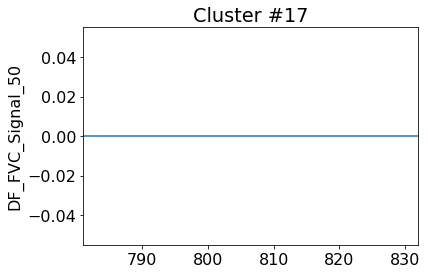

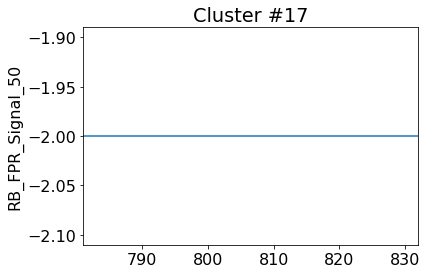

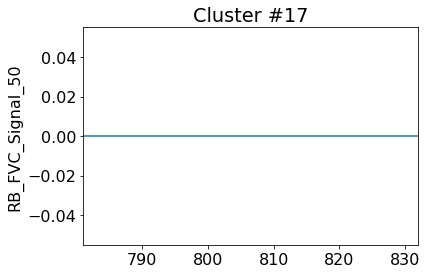

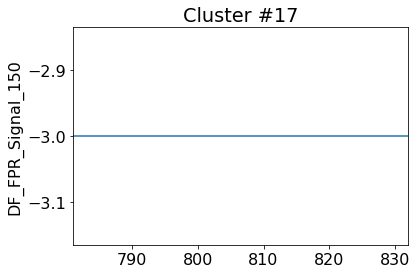

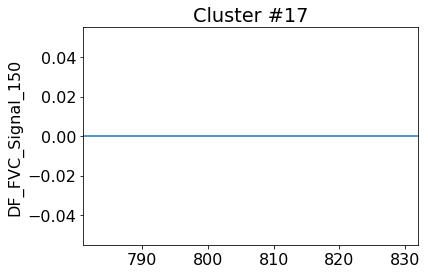

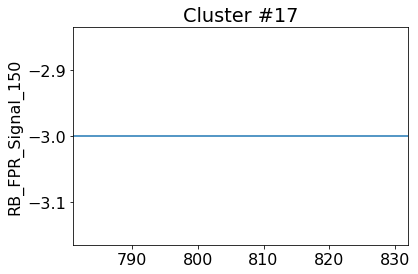

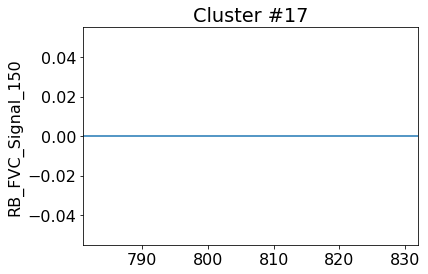

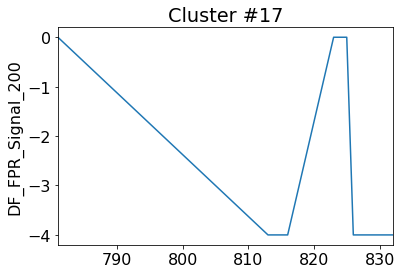

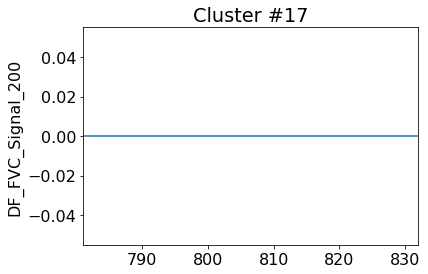

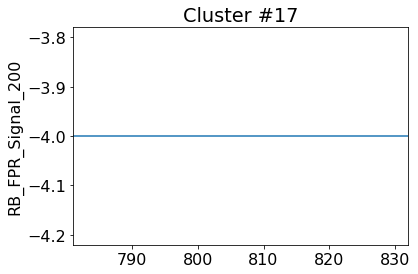

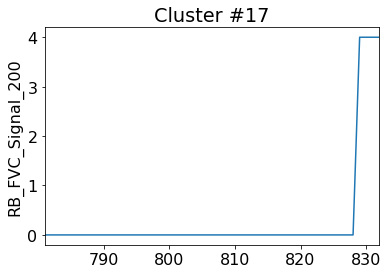

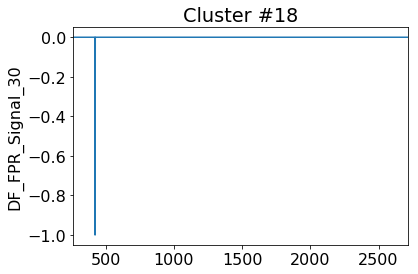

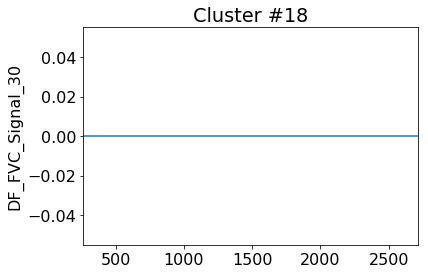

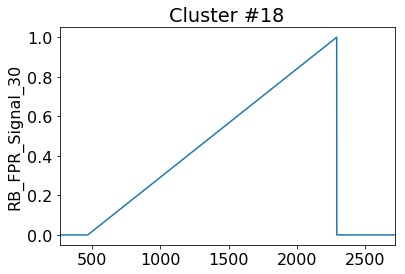

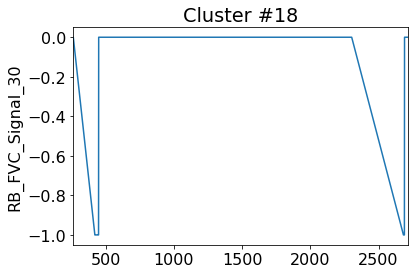

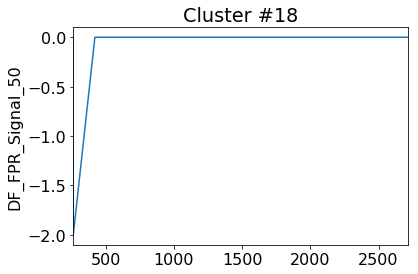

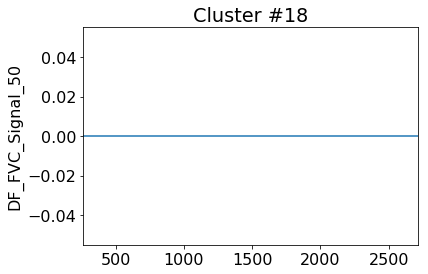

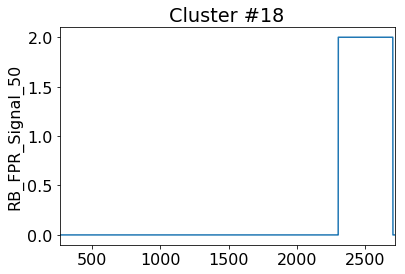

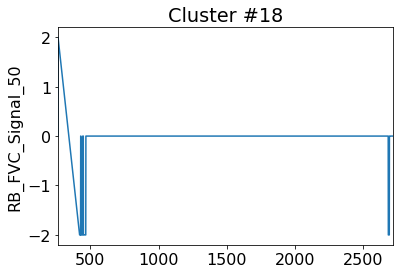

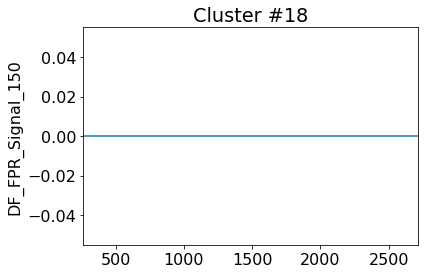

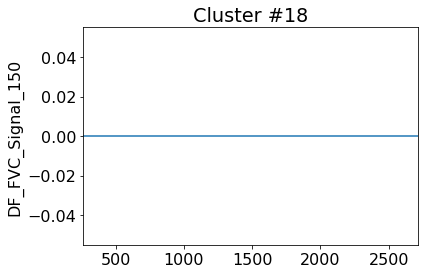

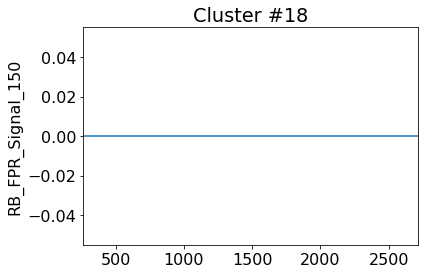

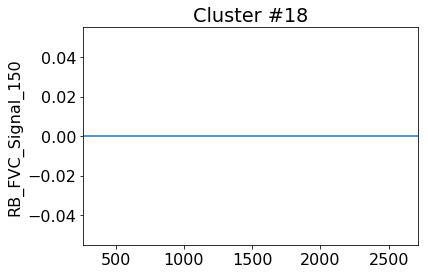

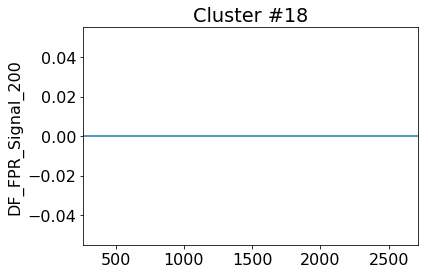

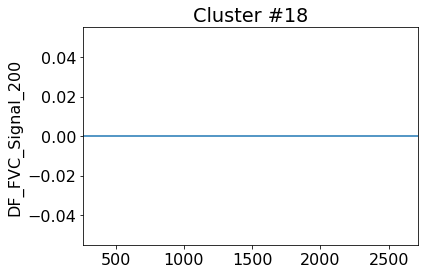

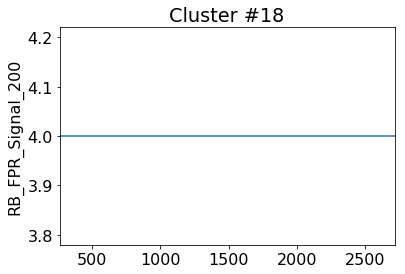

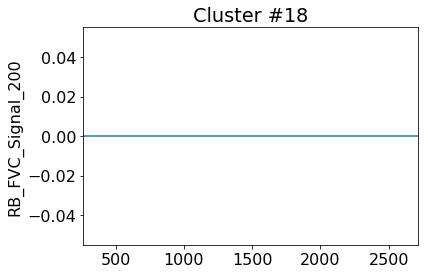

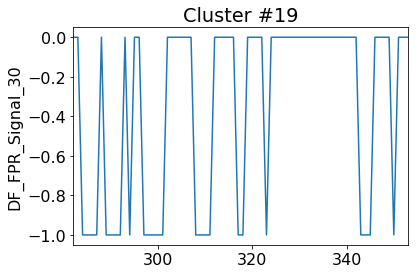

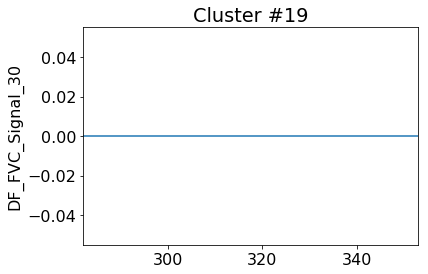

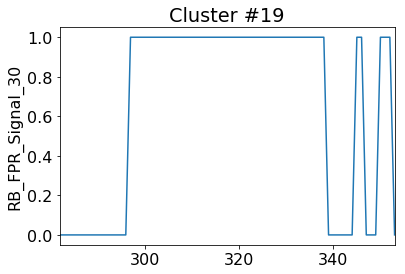

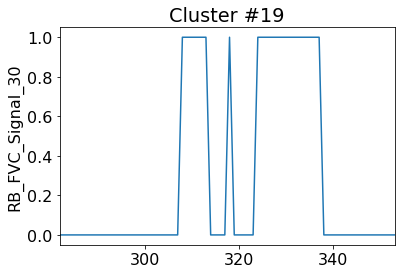

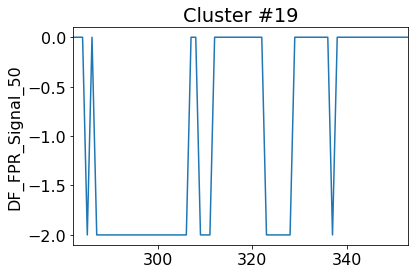

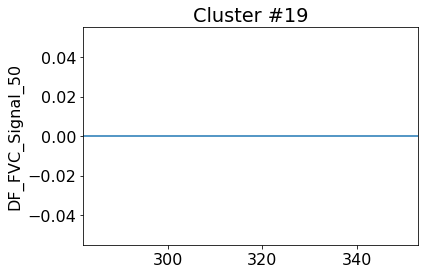

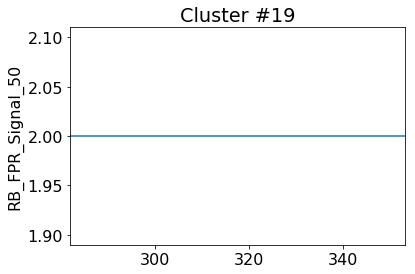

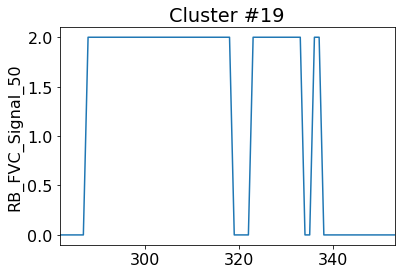

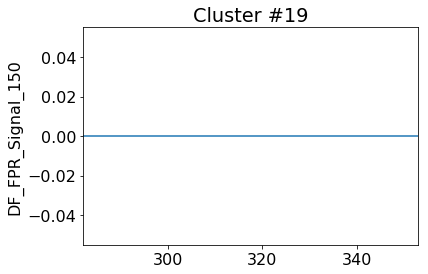

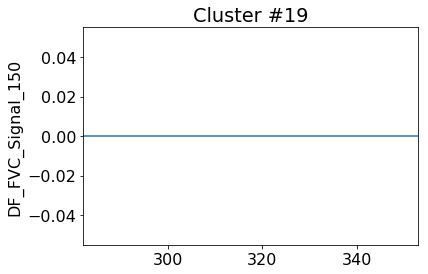

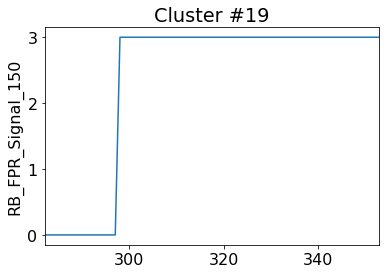

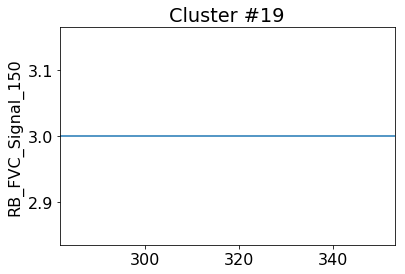

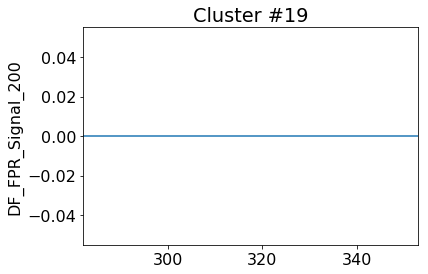

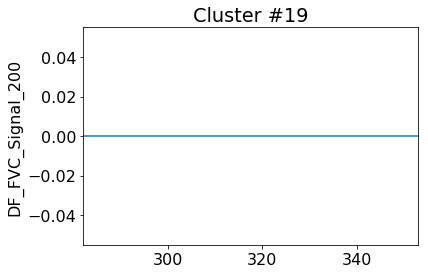

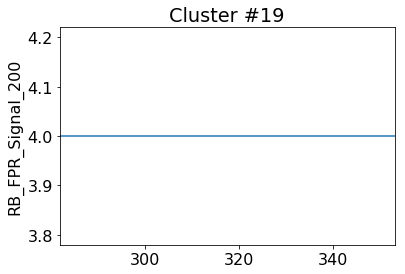

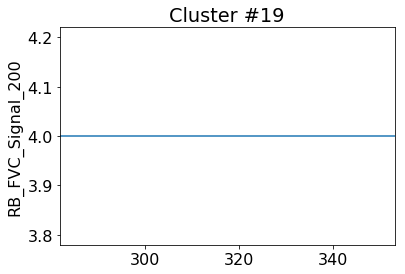

In [236]:
for x in range(20):
    c_title = 'Cluster #' + str(x)
    for i in signal_cols:
        pd_stock_data[stock_data['Cluster#']==x][i].plot()
        plt.title(c_title)
        plt.ylabel(i)
        plt.show()

In [237]:
pd_stock_data.to_csv(target_file_path)

In [238]:
pd_stock_data.head()

Unnamed: 0        Date   Open   High    Low  Close  Adj Close       Volume  \
0           0  2005-07-12  13.18  14.00  12.00  12.17   8.089035  244941515.0   
1           1  2005-07-13  12.20  12.60  11.49  11.74   7.803226   64111620.0   
2           2  2005-07-14  12.00  12.00  11.40  11.45   7.610473   16282865.0   
3           3  2005-07-15  11.25  12.89  11.25  12.37   8.221969   75448030.0   
4           4  2005-07-18  12.54  13.14  12.50  12.82   8.521070   75684775.0   

   % Change  % V_Change    ...     Roll_VMean_200  Roll_Change_200  \
0       NaN         NaN    ...                NaN              NaN   
1 -3.533279  -73.825744    ...                NaN              NaN   
2 -2.470187  -74.602319    ...                NaN              NaN   
3  8.034934  363.358445    ...                NaN              NaN   
4  3.637833    0.313786    ...                NaN              NaN   

   Roll_VChange_200  DF_Return_200  DF_VChange_200  DF_FPR_Signal_200  \
0               NaN     -43.210453    24800.021856                  0   
1               NaN     -44.068604    12906.759855                  0   
2               NaN     -45.914029     2125.407965                  0   
3               NaN     -40.096852     7227.648147                  0   
4               NaN     -36.250625     6757.244138                  0   

   DF_FVC_Signal_200  RB_FPR_Signal_200  RB_FVC_Signal_200  Cluster#  
0                  0                  0                  0         0  
1                  0                  0                  0         0  
2                  0                  0                  0         0  
3                  0                  0                  0         0  
4                  0                  0                  0         0  

[5 rows x 51 columns]

In [243]:
for i in signal_cols:
    print(pd_stock_data.pivot_table(index='Cluster#',columns=i,values='Date',aggfunc='count').div(len(pd_stock_data.index))*100)

DF_FPR_Signal_30        -1          0         1
Cluster#                                       
0                 1.718440  48.149372  1.024455
1                 0.165235   4.957039       NaN
2                 0.165235   0.462657  0.528751
3                 0.132188   6.345010  0.330469
4                      NaN        NaN  0.627892
5                 0.528751        NaN       NaN
6                 0.066094   1.354924  1.817581
7                      NaN   2.908130  0.231328
8                 0.033047   2.445473  0.330469
9                 0.066094   1.520159  0.760079
10                1.156642   3.502974       NaN
11                0.528751   1.916722  0.660939
12                0.958361        NaN       NaN
13                0.363516   0.528751  1.255783
14                0.693985   1.090549       NaN
15                     NaN   0.033047  0.495704
16                0.132188   3.899537  0.066094
17                0.231328   0.231328  0.033047
18                0.066094   3.106411   

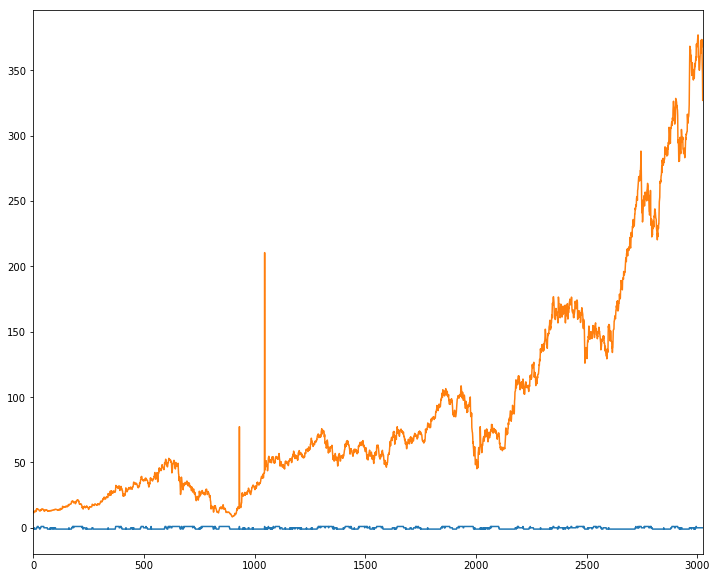

In [6]:
pd_stock_data['DF_FPR_Signal_30'].plot(figsize=(20,15))
pd_stock_data['Close'].plot(figsize=(12,10))
plt.show()

In [16]:
pd_stock_data[pd_stock_data['DF_FPR_Signal_30']==-1].count()

Unnamed: 0           1479
Date                 1479
Open                 1479
High                 1479
Low                  1479
Close                1479
Adj Close            1479
Volume               1479
% Change             1478
% V_Change           1478
Roll_Mean_30         1467
Roll_VMean_30        1467
Roll_Change_30       1467
Roll_VChange_30      1467
DF_Return_30         1479
DF_VChange_30        1479
DF_FPR_Signal_30     1479
DF_FVC_Signal_30     1479
RB_FPR_Signal_30     1479
RB_FVC_Signal_30     1479
Roll_Mean_50         1465
Roll_VMean_50        1465
Roll_Change_50       1459
Roll_VChange_50      1459
DF_Return_50         1473
DF_VChange_50        1473
DF_FPR_Signal_50     1479
DF_FVC_Signal_50     1479
RB_FPR_Signal_50     1479
RB_FVC_Signal_50     1479
Roll_Mean_150        1399
Roll_VMean_150       1399
Roll_Change_150      1348
Roll_VChange_150     1348
DF_Return_150        1428
DF_VChange_150       1428
DF_FPR_Signal_150    1479
DF_FVC_Signal_150    1479
RB_FPR_Signa